In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("Traffic.ipynb")

# Final Project: Traffic
## Due Date: Monday, December 13th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions within your own groups**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.

# Data 100 Final Project: Traffic in a post-lockdown world

**Scenario:** You're a data scientist at Uber -- sitting in a war room on March 16, 2020, 1 day after California-wide COVID lockdown measures began and the day shelter-in-place measures are announced in the bay area. The entire data science department is on fire: All of your existing traffic models have regressed *significantly*. Given the sudden change in traffic patterns (i.e., no traffic at all), the company's traffic estimates are wildly incorrect. This is a top priority for the company. Since traffic estimates are used directly for pricing strategies, this is actively costing the company millions every hour. You are tasked with fixing these models.

**Takeaways:** How do you "fix" models that have learned biases from pre-lockdown traffic? How do you train new ones, with just 24 hours of data? What sorts of data do you examine, to better understand the situation? In the midst of company-wide panic, you'll need a strong inferential acumen to lead a robust data science response. In this project, we'll walk you through a simulated war room data science effort, culminating in some strategies to fix models online, which are experiencing large distributional shifts in data.

For this project, we'll explore traffic data provided by the **Uber Movement** dataset, specifically around the start of COVID shutdowns in March 2020. Your project is structured around the following ideas:

```
1. Guided data cleaning: Clustering data spatially
    a. Load Uber traffic speeds dataset
    b. Map traffic speeds to Google Plus Codes (spatially uniform)
        i. Load node-to-gps-coordinates data
        ii. Map traffic speed to GPS coordinates
        iii. Convert GPS coordinates to plus code regions
        iv. Sanity check number of plus code regions in San Francisco
        v. Plot a histogram of the standard deviation in speed, per plus code region.
    c. Map traffic speeds to census tracts (spatially non-uniform)
        i. Download census tracts geojson
        ii. Map traffic speed to census tracts
        iii. Sanity check number of census tracts in San Francisco with data.
        iv. Plot a histogram of the standard deviation in speed, per census tract.
    d. What defines a "good" or "bad" spatial clustering?
2. Guided EDA: Understanding COVID lockdown impact on traffic
    a. How did lockdown affect average traffic speeds?
        i. Sort census tracts by average speed, pre-lockdown.
        ii. Sort census tracts by average speed, post-lockdown.
        iii. Sort census tracts by change in average speed, from pre to post lockdown.
        iv. Quantify the impact of lockdown on average speeds.
        v. Quantify the impact of pre-lockdown average speed on change in speed.
    b. What traffic areas were impacted by lockdown?
        i. Visualize heatmap of average traffic speed per census tract, pre-lockdown.
        ii. Visualize change in average daily speeds pre vs. post lockdown.
        iii. Quantify the impact of lockdown on daily speeds, spatially.
3. Open-Ended EDA: Understanding lockdown impact on traffic times
    a. Download Uber Movement (Travel Times) dataset
4. Guided Modeling: Predict traffic speed post-lockdown
    a. Predict daily traffic speed on pre-lockdown data
        i. Assemble dataset to predict daily traffic speed.
        ii. Train and evaluate linear model on pre-lockdown data.
    b. Understand failures on post-lockdown data
        i. Evaluate on post-lockdown data
        ii. Report model performance temporally
    c. "Fix" model on post-lockdown data
        i. Learn delta off of a moving bias
        ii. Does it "solve itself"? Does the pre-lockdown model predict, after the change point?
        iii. Naively retrain model with post-lockdown data
        iv. What if you just ignore the change point?
5. Open-Ended Modeling: Predicting travel times post-lockdown
```

Concepts tested: regex, pivot, join, grouping, inferential thinking

In [2]:
# please uncomment the pip install below, we commented it to enable Gradescope autograder to run. 
# %pip install --quiet scikit-optimize

Note: you may need to restart the kernel to use updated packages.


In [3]:
# please uncomment 'import BayesSearchCV', we commented it to enable Gradescope autograder to run. 
import pandas as pd
import geopandas as gpd
import numpy as np
import csv
import json
import os
import contextily as cx
from collections import defaultdict
import re
from typing import Callable
from datetime import datetime
from collections import OrderedDict

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
# from skopt import BayesSearchCV
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from zipfile import ZipFile
zf = ZipFile('data.zip', 'r')
zf.extractall('.')

import warnings
warnings.filterwarnings("ignore")

In [4]:
# more readable exceptions
%pip install --quiet iwut
%load_ext iwut
%wut on

Note: you may need to restart the kernel to use updated packages.


# Step 1 - Guided Data Cleaning: Partitioning Data Spatially

Our hope is answer: How do we group information spatially? We'll specifically look at 2 ways of partitioning data spatially, to understand the impact of spatial partitioning strategies on our analyses:

1. Dividing the world uniformly into slices, like Google's plus codes.
2. Dividing the world according to population, using census tracts.

In this step, we'll load the following datasets that we'll need for this project:

- Daily travel times from Uber Movement data in March 2020 from San Francisco, by census tract
- Daily traffic speeds from Uber Movement data in Q1 2020 from San Francisco, between OSM nodes
- Census tracts dividing San Francisco by GPS coordinates
- Mapping from OSM nodes to GPS coordinates

There are several terms and concepts to get familiar with upfront:

- **Open Street Maps (OSM)** provides nodes (points in space, [wiki](https://wiki.openstreetmap.org/wiki/Node)) and ways (segments between nodes [wiki](https://wiki.openstreetmap.org/wiki/Way)). These IDs are used in the Uber Movement dataset to identify streets in the traffic speeds dataset.
- **Census Tracts** provided by the county of San Francisco geographically divides space according to the US 2010 Census. This is used in the Uber Movement dataset to identify regions of differing travel times.

## 1.a. Load Uber traffic speeds dataset

The dataset is located at `data/movement-speeds-daily-san-francisco-2020-3.csv`. **Load this dataset into a dataframe.**

*The original dataset from Uber was provided hourly and took up 2.1 GB on disk, which means it couldn't fit into your 1GB of RAM. You can find the dataset preparation script at `data/PrepareTrafficDataset.ipynb` which aggregated within each day, reducing the dataset to just 55MB on disk.*

*This was originally going to be question in this project, but it takes 22 minutes to run. Better yet, if you mess up, your kernel dies and you start over. We deemed it too frustrating and preprocessed the dataset to spare you the pain... but just know that this is a real-world issue!*

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [5]:
# Load Uber Movement (Movement Speeds) dataset into dataframe
speeds_to_nodes = pd.read_csv('data/movement-speeds-daily-san-francisco-2020-3.csv')

speeds_to_nodes

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean
0,281266,702258940,1,59.674042
1,281266,702274215,1,68.444042
2,302876,240259516,1,66.446500
3,302878,437325360,1,65.516850
4,302883,65381191,1,61.880556
...,...,...,...,...
1586647,6569140748,1350115374,31,68.484833
1586648,6570476556,4551993266,31,36.837000
1586649,6573249373,4911384010,31,39.021000
1586650,6573553681,256888796,31,68.728333


In [6]:
grader.check("q1a")

q1a results: All test cases passed!

<!-- BEGIN QUESTION -->

## 1.b. Map traffic speed to Google Plus Codes

Google Plus Codes divide up the world uniformly into rectangular slices ([link](https://maps.google.com/pluscodes/)). Let's use this to segment traffic speeds spatially. Take a moment to answer: **Is this spatial structure effective for summarizing traffic speed?** Before completing this section, substantiate your answer with examples of your expectations (e.g., we expect A to be separated from B). After completing this section, substantiate your answer with observations you've made.

<!--
BEGIN QUESTION
name: q1b
points: 2
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->



### 1.b.i. Load Node-to-GPS-Coordinate Data

In this substep, we'll load a mapping from OSM nodes to GPS coordinates. The dataset is provided in a gzip'ed XML file from OpenStreetMaps (OSM). The mapping from OSM nodes to GPS coordinates was downloaded from https://download.bbbike.org/osm/bbbike/SanFrancisco/SanFrancisco.osm.gz. We've downloaded this for you, to avoid any issues with OSM updates.

**If** you try to load the provided `.osm` (an `.xml` in disguise) using Python's built-in XML utilities **(by uncommenting the last 2 lines in the below cell)**, you will hit an out-of-memory error, as your kernel is forced to restart.

In [7]:
# [OSM] - Read the OSM XML and extract mapping from node ID to GPS coordinates
PATH_OSM = os.path.expanduser('data/SanFrancisco.osm')

# Runs out of memory! File itself is 430 MB, even when filtering out
# irrelevant rows, and remaining 3M rows are too expensive to parse,
# resulting in OOM

# import xml.etree.ElementTree as ET
# _tree = ET.parse(PATH_OSM)

Your above code hits a memory error, so instead, we will use our handy-dandy tool--regex--from earlier in the semester to load just the parts of the file that we need. **Given the XML snippet below, write a regex pattern to extract OSM node ID, latitude, and longitude.** (The first capture group should be node ID. The second should be latitude, and the third should be longitude.) A snippet of the XML is included below ([screenshot](https://extract.bbbike.org/extract-screenshots.html)):

```
<?xml version='1.0' encoding='UTF-8'?>
<osm version="0.6" generator="osmconvert 0.8.3">
    <bounds minlat="42.4543" minlon="-2.4761999" maxlat="42.4..."/>
    <node id="26861066" lat="42.471111" lon="-2.454722" version="..."/>
        <tag k="name" v="Camping La Playa"/>
        <tag k="tourism" v="camp_site"/>
        <tag k="operator" v="private"/>
        ...
    </node>
    <node id="34793287" lat="42.4713587" lon="-2.4510783" version="..."/>
        <tag k="created_by" v="JOSM"/>
    </node>
    <node id="34793294" lat="42.4610836" lon="-2.4303622" version="..."/>
    <node id="34793297" lat="42.4548363" lon="-2.4287657" version="..."/>
    ...
</osm>
```

In [8]:
# [OSM] - Read the OSM XML using a regex operation instead.
def read_node_lat_lon(path: str, pattern: str, line_condition: Callable):
    """
    Read the provided path line at a line. If the provided regex pattern
    has a match, return the grouped matches as items in a generator.
    
    :param path: Path to read data from
    :param pattern: Regex pattern to test against each line
    :param line_condition: function that returns if we should check regex
        against current line
    """
    with open(path) as f:
        for line in f:
            result = re.search(pattern, line)
            if result is not None and line_condition(result):
                yield int(result.group(1)), float(result.group(2)), float(result.group(3))

In [9]:
node_ids = set(speeds_to_nodes.osm_start_node_id) | set(speeds_to_nodes.osm_end_node_id)

NODE_PATTERN = r'<node id="(\d*)" lat="(-?\d*\.?\d*)" lon="(-?\d*\.?\d*)"'

node_to_gps = pd.DataFrame(read_node_lat_lon(
    PATH_OSM,
    pattern=NODE_PATTERN,
    line_condition=lambda result: int(result.group(1)) in node_ids
), columns=['osm_node_id', 'Latitude', 'Longitude'])
node_to_gps

,osm_node_id,Latitude,Longitude
0,26118026,37.675280,-122.389194
1,29891973,37.674935,-122.389130
2,29892598,37.716892,-122.398893
3,30033679,37.599877,-122.376497
4,30033686,37.642167,-122.405946
...,...,...,...
19139,6522255428,37.760543,-122.443563
19140,6522255492,37.759317,-122.444996
19141,6522764204,37.762163,-122.436143
19142,6522764212,37.756061,-122.436761


In [10]:
grader.check("q1bi")

q1bi results: All test cases passed!

### 1.b.ii. Map traffic speed to GPS coordinates.

Traffic speeds are currently connected to OSM nodes. You will then use the mapping from OSM nodes to GPS coordinates, to map traffic speeds to GPS coordinates. **Link each traffic speed measurement to the GPS coordinate of its starting node.**

**Note**: For simplicity, assume each segment is associated with the node it *starts* with. 

**Hint**: Not all nodes are included in the OSM node mapping. Make sure to ignore any nodes without valid GPS coordinates.

<!--
BEGIN QUESTION
name: q1bii
points: 3
-->

In [11]:
# Find mapping from traffic speeds to GPS coordinates
speeds_to_gps = speeds_to_nodes.merge(node_to_gps, left_on='osm_start_node_id', right_on='osm_node_id')
speeds_to_gps

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,osm_node_id,Latitude,Longitude
0,26118026,259458979,1,64.478000,26118026,37.675280,-122.389194
1,26118026,259458979,2,62.868208,26118026,37.675280,-122.389194
2,26118026,259458979,3,62.211750,26118026,37.675280,-122.389194
3,26118026,259458979,4,62.192458,26118026,37.675280,-122.389194
4,26118026,259458979,5,61.913292,26118026,37.675280,-122.389194
...,...,...,...,...,...,...,...
417634,4069109544,615120176,30,38.956000,4069109544,37.732039,-122.507126
417635,5448539901,65446993,16,25.627000,5448539901,37.622476,-122.413763
417636,302964668,4069109544,19,40.802000,302964668,37.732418,-122.507206
417637,302964668,4069109544,20,36.076000,302964668,37.732418,-122.507206


In [12]:
grader.check("q1bii")

q1bii results: All test cases passed!

### 1.b.iii. Convert GPS coordinates to plus code regions.

Plus code regions divide up the world into uniformly-sized rectangles, which we will assume is 0.012 degrees latitudiunally and longitudinally. **For each traffic speed row, compute the plus code region it belongs to**, based on its GPS coordinates.

To do this, we suggest computing a latitudinal index `plus_latitude_idx` and a longitudinal index `plus_longitude_idx` for the plus code region each row belongs to. *Make sure these columns are integer-valued*.

**Hint**: If you're running into nans, you did 1.b.ii. incorrectly!

<!--
BEGIN QUESTION
name: q1biii
points: 3
-->

In [13]:
speeds_to_gps['plus_latitude_idx'] = (speeds_to_gps['Latitude']/0.012).astype(int)
speeds_to_gps['plus_longitude_idx'] =(speeds_to_gps['Longitude']/0.012).astype(int)
speeds_to_gps

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,osm_node_id,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx
0,26118026,259458979,1,64.478000,26118026,37.675280,-122.389194,3139,-10199
1,26118026,259458979,2,62.868208,26118026,37.675280,-122.389194,3139,-10199
2,26118026,259458979,3,62.211750,26118026,37.675280,-122.389194,3139,-10199
3,26118026,259458979,4,62.192458,26118026,37.675280,-122.389194,3139,-10199
4,26118026,259458979,5,61.913292,26118026,37.675280,-122.389194,3139,-10199
...,...,...,...,...,...,...,...,...,...
417634,4069109544,615120176,30,38.956000,4069109544,37.732039,-122.507126,3144,-10208
417635,5448539901,65446993,16,25.627000,5448539901,37.622476,-122.413763,3135,-10201
417636,302964668,4069109544,19,40.802000,302964668,37.732418,-122.507206,3144,-10208
417637,302964668,4069109544,20,36.076000,302964668,37.732418,-122.507206,3144,-10208


In [14]:
grader.check("q1biii")

q1biii results: All test cases passed!

### 1.b.iv. Sanity check number of plus code regions in San Francisco.

**Compute the number of unique plus codes found in your dataset**. You're checking that the number isn't ridiculous, like 1, or 100,000 (SF is 231 sq mi, so 100k tracts would average 12 sq ft per tract).

If you followed the suggestion above, this is the number of unique `(plus_latitude_idx, plus_longitude_idx)` pairs.

<!--
BEGIN QUESTION
name: q1biv
points: 4
-->

In [15]:
# You're expecting 276 plus codes here. Don't just type "276" 
# below to pass the autograder. The goal is to sanity check your 
# dataframe!
grouped_pluscode_regions = speeds_to_gps.groupby(['plus_latitude_idx', 'plus_longitude_idx']).size()
num_pluscode_regions = grouped_pluscode_regions.shape[0]
num_pluscode_regions

276

In [16]:
grader.check("q1biv")

q1biv results: All test cases passed!

<!-- BEGIN QUESTION -->

### 1.b.v. How well do plus code regions summarize movement speeds?

The following will give us an idea of how well the average represents traffic speed per plus code region. For these questions, we'll refer to a "plus code region" as a "cluster":

1. **Plot a histogram of the within-cluster standard deviation**.
2. **Compute across-cluster average of within-cluster standard deviation**.
3. **Compute across-cluster standard deviation of within-cluster average speeds**.
4. **Is this average variance reasonable?** To assess what "reasonable" means, consider these questions and how to answer them: (1) Do plus codes capture meaningful subpopulations? (2) Do differences between subpopulations outweigh differences within a subpopulation? Use the statistics above to answer these questions, and compute any additional statistics you need. Additionally explain *why these questions are important to assessing the quality of a spatial clustering*.

**Hint**: Run the autograder first to ensure your variance average and average variance are correct, before starting to draw conclusions.

In the first cell, write your written answers. In the second cell, complete the code.

<!--
BEGIN QUESTION
name: q1bv1
points: 2
manual: True
-->



A high standard deviation within a cluster indicates that the speed_mph_mean had high variability within that cluster. In this scenario, there is a larger average standard deviation which is unreasonable because this would mean the speed_mph_mean among the clusters were not close in values. Thus, the clusters formed by the plus codes do not capture meaningful subpopulations since the average speeds within those clusters vary so much. The standard deviation between subpopulations average speeds are 10.1 mph, while the standard deviation within a subpopulation is around 8.7 mph, which is very close to the previous number, further indicating that the individual clusters are not that meaningful. To conclude that the clusters are meaningful we would have expected the second (standard deviation within clusters)to be much lower than the first (standard deviation across clusters). These questions are important because they help us determine how clusters are able to separate the data and if the separation is meaningful based on how similar the data within each cluster is to each other.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q1bv2
points: 2
manual: True
-->

average_std_by_pluscode: 8.684748294968637
std_average_by_pluscode: 10.13573858675904


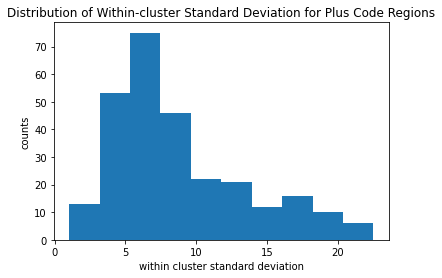

In [17]:
# Note: We kept the word variance for auto-grading purposes, even though it is actually the standard deviation

# Question 1
speed_variance_by_pluscode = \
(speeds_to_gps
     .groupby(['plus_latitude_idx', 'plus_longitude_idx'])['speed_mph_mean']
     .agg('std')# compute traffic speed variance in each plus code region
)
# plot a histogram
plt.hist(x=speed_variance_by_pluscode)
plt.xlabel('within cluster standard deviation')
plt.ylabel('counts')
plt.title('Distribution of Within-cluster Standard Deviation for Plus Code Regions')

# Question 2
average_variance_by_pluscode = speed_variance_by_pluscode.mean()
print(f"average_std_by_pluscode: {average_variance_by_pluscode}")

# Question 3
variance_average_by_pluscode = \
((speeds_to_gps
     .groupby(['plus_latitude_idx', 'plus_longitude_idx'])['speed_mph_mean']
     .agg('mean')).std()
)
print(f"std_average_by_pluscode: {variance_average_by_pluscode}")

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q1bv3
points: 3
-->

In [18]:
speed_variance_by_pluscode

plus_latitude_idx  plus_longitude_idx
3128               -10209                 3.650232
                   -10197                20.704487
                   -10193                12.342234
3129               -10209                 4.083821
                   -10198                21.390912
                                           ...    
3160               -10197                15.293632
                   -10196                17.915911
                   -10195                14.243592
                   -10194                12.237229
                   -10193                17.590817
Name: speed_mph_mean, Length: 276, dtype: float64

In [19]:
grader.check("q1bv3")

q1bv3 results: All test cases passed!

## 1.c. Map traffic speed to census tract.

Census tracts divide the space much less uniformly, subdividing regions that we were interested in into smaller zones. This suggests promise in providing informative spatial segments. Note that the daily traffic speeds are provided between OpenStreetMap (OSM) nodes, so we'll need to map nodes to census tracts somehow.

Above, we've mapped traffic speeds to GPS coordinates. Below, we'll then link GPS coordinates to census tracts, to complete the mapping from traffic speeds to census tracts.

### 1.c.i. Download Census Tracts Geojson

**Load the census tracts geojson.** Make sure to see the relevant [geopandas io documentation](https://geopandas.org/docs/user_guide/io.html) to see how to load a geojson.

**Hint**: It should take you just one line to load.

<!--
BEGIN QUESTION
name: q1ci
points: 1
-->

In [20]:
PATH_TRACTS = os.path.expanduser('data/san_francisco_censustracts.json')
tract_to_gps = gpd.read_file(PATH_TRACTS)
tract_to_gps['MOVEMENT_ID'] = tract_to_gps['MOVEMENT_ID'].astype(int)
tract_to_gps

,MOVEMENT_ID,DISPLAY_NAME,geometry
0,1,"Sargent Creek, San Ardo","MULTIPOLYGON (((-121.59511 36.11126, -121.5401..."
1,2,"400 Northumberland Avenue, Redwood Oaks, Redwo...","MULTIPOLYGON (((-122.22463 37.46507, -122.2236..."
2,3,"18300 Sutter Boulevard, Morgan Hill","MULTIPOLYGON (((-121.67978 37.15859, -121.6719..."
3,4,"2700 Stoughton Way, Sheffield, Sacramento","MULTIPOLYGON (((-121.35921 38.57175, -121.3462..."
4,5,"3200 Huntsman Drive, Rosemont Park, Sacramento","MULTIPOLYGON (((-121.37512 38.55309, -121.3715..."
...,...,...,...
2705,2706,"10000 Bobbell Drive, Elk Grove","MULTIPOLYGON (((-121.48392 38.40874, -121.4787..."
2706,2707,"400 Ericwood Court, Manteca","MULTIPOLYGON (((-121.22695 37.82647, -121.2185..."
2707,2708,"200 Westview Drive, Sunshine Gardens, South Sa...","MULTIPOLYGON (((-122.45179 37.66912, -122.4506..."
2708,2709,"1200 Halyard Drive, West Sacramento","MULTIPOLYGON (((-121.58346 38.57860, -121.5827..."


In [21]:
grader.check("q1ci")

q1ci results: All test cases passed!

### 1.c.ii Map traffic speed to census tracts.

You will need to *spatially join* the (1) mapping from traffic speed to GPS coordinates `speed_to_gps` and (2) the mapping from GPS coordinates to boundaries of census tracts `tract_to_gps` to group all traffic speeds by census tract. This "spatial join" is an advanced feature recently released (as of time of writing, in Oct 2021) in geopandas, which allows us to connect single points to their enclosing polygons. You will do this question in 3 parts:

1. Convert the last dataframe `speeds_to_gps` into a geopandas dataframe `speeds_to_points`, where GPS coordinates are now geopandas points. See this tutorial: https://geopandas.org/gallery/create_geopandas_from_pandas.html#From-longitudes-and-latitudes
2. Set the coordinate-system for the new geopandas dataframe to the "world geodesic system" [link](https://epsg.io/4326), or in other words, the coordinate system that GPS coordinates are reported in.
3. Compute a spatial join between census tracts `tract_to_gps` and the geopandas traffic speeds `speeds_to_points`

<!--
BEGIN QUESTION
name: q1cii
points: 4
-->

In [22]:
speeds_to_points = gpd.GeoDataFrame(speeds_to_gps, geometry=gpd.points_from_xy(speeds_to_gps.Longitude, speeds_to_gps.Latitude), crs = "EPSG:4326")

speeds_to_tract = speeds_to_points.sjoin(tract_to_gps, how='left', predicate='intersects')

speeds_to_tract

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,osm_node_id,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx,geometry,index_right,MOVEMENT_ID,DISPLAY_NAME
0,26118026,259458979,1,64.478000,26118026,37.675280,-122.389194,3139,-10199,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
1,26118026,259458979,2,62.868208,26118026,37.675280,-122.389194,3139,-10199,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
2,26118026,259458979,3,62.211750,26118026,37.675280,-122.389194,3139,-10199,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
3,26118026,259458979,4,62.192458,26118026,37.675280,-122.389194,3139,-10199,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
4,26118026,259458979,5,61.913292,26118026,37.675280,-122.389194,3139,-10199,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
417634,4069109544,615120176,30,38.956000,4069109544,37.732039,-122.507126,3144,-10208,POINT (-122.50713 37.73204),1778,1779,"500 John Muir Drive, Lakeshore, San Francisco"
417635,5448539901,65446993,16,25.627000,5448539901,37.622476,-122.413763,3135,-10201,POINT (-122.41376 37.62248),1456,1457,"1500 Donner Avenue, San Bruno"
417636,302964668,4069109544,19,40.802000,302964668,37.732418,-122.507206,3144,-10208,POINT (-122.50721 37.73242),1778,1779,"500 John Muir Drive, Lakeshore, San Francisco"
417637,302964668,4069109544,20,36.076000,302964668,37.732418,-122.507206,3144,-10208,POINT (-122.50721 37.73242),1778,1779,"500 John Muir Drive, Lakeshore, San Francisco"


In [23]:
grader.check("q1cii")

q1cii results: All test cases passed!

### 1.c.iii. Aggregate movement speeds by census tract.

- Create a new dataframe `speeds_by_tract` to group movement speeds by census tract. See the outputted dataframe from 1.c.i. to check how census tracts are identified.
- Always double-check your numbers. **Report the number of census tracts** in your dataset.

<!--
BEGIN QUESTION
name: q1ciii
points: 2
-->

In [24]:
speeds_by_tract = speeds_to_tract.dissolve(by='MOVEMENT_ID', aggfunc='count')

num_census_tracts = speeds_by_tract.shape[0]
num_census_tracts

295

In [25]:
grader.check("q1ciii")

q1ciii results: All test cases passed!

<!-- BEGIN QUESTION -->

### 1.c.iv. How well do census tracts summarize movement speeds?

The following will give us an idea of how well the average represents traffic speed per plus code region. For these questions, we'll refer to a "census tract" as a "cluster":

1. **Plot a histogram of the within-cluster standard deviation**.
2. **Compute across-cluster average of within-cluster standard deviation**.
3. **Compute across-cluster standard deviation of within-cluster average speeds**.
4. **Is this average variance reasonable?** To assess what "reasonable" means, consider these questions and how to answer them: (1) Do plus codes capture meaningful subpopulations? (2) Do differences between subpopulations outweigh differences within a subpopulation? Use these ideas to assess whether the average standard deviation is high or not.

Note: We are using the speed metric of miles per hour here.

Just like before, please written answers in the first cell and coding answers in the second cell.
<!--5. Using the above, how would you **compare census tracts to plus codes, in terms of its effectiveness** as a spatial clustering mechanism for analyzing traffic speeds? Compare the statistics you've computed. What does it mean for one to be higher than the other?-->

<!--
BEGIN QUESTION
name: q1civ1
points: 2
manual: True
-->



With an average standard deviation of around 8, this is not reasonable. The clusters captured by census tracts are not meaningful since the data points within the clusters have high variability for their speed_mph_mean, leading to a larger within-cluster standard deviation. However, the values for standard deviation averages across cluster has decreased for clusters formed by plus codes (10.136) when compared to clusters formed by census tracts (8.346). In contrast, the values for average standard deviation by cluster has stayed similar across plus code clusters (8.645) and census tracts clusters (8.300). Although there is a slight decrease in the dispersion between subpopulations, the average standard deviation is still high.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q1civ2
points: 2
manual: True
-->

average_std_by_tract: 8.300873802949297
std_average_by_tract: 8.346122597861662


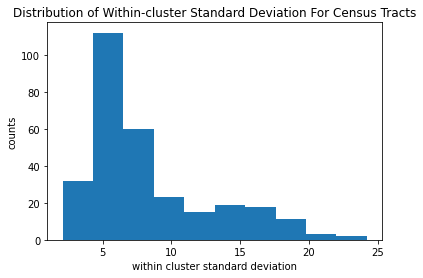

In [26]:
speed_variance_by_tract = speeds_to_tract.dissolve(by='MOVEMENT_ID', aggfunc='std')['speed_mph_mean']

plt.hist(x=speed_variance_by_tract)
plt.xlabel('within cluster standard deviation')
plt.ylabel('counts')
plt.title('Distribution of Within-cluster Standard Deviation For Census Tracts')

average_variance_by_tract = speed_variance_by_tract.mean()
variance_average_by_tract = speeds_to_tract.dissolve(by='MOVEMENT_ID', aggfunc='mean')['speed_mph_mean'].std()

print(f"average_std_by_tract: {average_variance_by_tract}")
print(f"std_average_by_tract: {variance_average_by_tract}")

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q1civ3
points: 3
-->

In [27]:
speed_variance_by_tract

MOVEMENT_ID
9        3.821144
20       5.522853
21       3.640453
44       6.634154
78       3.838873
          ...    
2691     3.379664
2694     5.787065
2695     4.617596
2700    13.191079
2708     7.136608
Name: speed_mph_mean, Length: 295, dtype: float64

In [28]:
grader.check("q1civ3")

q1civ3 results: All test cases passed!

<!-- BEGIN QUESTION -->

## 1.d. What would be the ideal spatial clustering?

This is an active research problem in many spatiotemporal modeling communities, and there is no single agreed-upon answer. Answer both of the following specifically knowing that you'll need to analyze traffic patterns according to this spatial clustering:

1. **What is a good metric for a spatial structure?** How do we define good? Bad? What information do we expect a spatial structure to yield? Use the above parts and questions to help answer this.
2. **What would you do to optimize your own metric for success in a spatial structure?**

See related articles:

- Uber's H3 [link](https://eng.uber.com/h3/), which divides the world into hexagons
- Traffic Analysis Zones (TAZ) [link](https://en.wikipedia.org/wiki/Traffic_analysis_zone), which takes census data and additionally accounts for vehicles per household when dividing space

<!--
BEGIN QUESTION
name: q1d
points: 3
manual: True
-->

A good spatial structure should allow for capturing clusters that have low variability in the features that we are interested in (ex: speed_mph_mean). A bad spatial cluster would capture clusters with high within-cluster standard deviations, meaning the clusters it captures are rendered meaningless since the data points within the clusters are not highly similar. With this in mind, it is expected that a spatial structure yields information where the clusters formed have statistics that reflect the points within those clusters.

An example spatial structure that may be beneficial would be to draw circles of regions, whose radii is determined by the number of people in that location (census data) along with the number of vehicles per household. Considering the relative numbers of people according to your geographic location is important as it can reveal insight to traffic in those areas. Likewise, taking into account the number of vehicles per household is also important since our problem is concerning traffic patterns.

To optimize our own metric for success in a spatial structure, statistics could be computed within clusters and across clusters and compared for variability. This process can be repeated and the clusters can be readjusted until the variance function is minimized.

<!-- END QUESTION -->



# Step 2 - Guided EDA: Understanding COVID Lockdown Impact on Traffic

In this step, we'll examine the impact of COVID on traffic. In particular, we'll study 3 different questions:

- How did lockdown affect traffic speed? What factors dictate how much lockdown affected traffic speed?
- What areas of traffic were most impacted by lockdown?

## 2.a. How did lockdown affect traffic speed?

<!-- BEGIN QUESTION -->

### 2.a.i. Sort census tracts by average speed, pre-lockdown.

Consider the pre-lockdown period to be March 1 - 13, before the first COVID-related restrictions (travel bans) were announced on March 14, 2020.

1. **Report a DataFrame which includes the *names* of the 10 census tracts with the lowest average speed**, along with the average speed for each tract.
2. **Report a DataFrame which includes the *names* of the 10 census tracts with the highest average speed**, along with the average speed for each tract.
2. Do these names match your expectations for low speed or high speed traffic pre-lockdown?  What relationships do you notice? (What do the low-speed areas have in common? The high-speed areas?) For this specific question, answer qualitatively. No need to quantify. **Hint**: Look up some of the names on a map, to understand where they are.
3. **Plot a histogram for all average speeds, pre-lockdown**.
4. You will notice a long tail distribution of high speed traffic. What do you think this corresponds to in San Francisco? Write down your hypothesis.

Hint: To start off, think about what joins may be useful to get the desired DataFrame.

<!--
BEGIN QUESTION
name: q2ai1
points: 3
manual: True
-->

Yes, the tract names match our expectations. The tracts with the lowest average speeds tend to be in more central areas of San Francisco, like Mission District, Tenderloin, or Chinatown, where we expect more congestion. The highest average speeds where in zones far from the urban centers, like Half Moon Bay, Richmond, Sausalito and San Bruno, to name a few. In fact, given the high speeds on these last ones, it is very likely that there is a highway going through each of the tracts.

<!-- END QUESTION -->

Answer the following question:
<!--
BEGIN QUESTION
name: q2ai2
points: 3
-->

In [29]:
# compute the average speed per census tract (will use this later),
# BEFORE the shelter-in-place was announced on March 14, 2020.
# Autograder expects this to be a series
bool_pre = speeds_to_tract.day < 14
averages_pre = \
(speeds_to_tract
     .loc[bool_pre, ['MOVEMENT_ID', 'speed_mph_mean']]
     .groupby('MOVEMENT_ID')['speed_mph_mean']
     .mean()
)
# Autograder expects this to be a dataframe with name of census tract,
# polygon for census tract, and average speed per census tract
averages_pre_named = tract_to_gps.merge(averages_pre, left_on='MOVEMENT_ID', right_on='MOVEMENT_ID')
averages_pre_named

,MOVEMENT_ID,DISPLAY_NAME,geometry,speed_mph_mean
0,9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",14.585102
1,20,"900 Sutter Street, Lower Nob Hill, San Francisco","MULTIPOLYGON (((-122.42208 37.78847, -122.4153...",15.679922
2,21,"3400 Pierce Street, Marina District, San Franc...","MULTIPOLYGON (((-122.44191 37.80374, -122.4371...",14.292445
3,44,"1700 Egbert Avenue, Bayview, San Francisco","MULTIPOLYGON (((-122.40211 37.72779, -122.3998...",23.353083
4,78,"1400 Thomas Avenue, Bayview, San Francisco","MULTIPOLYGON (((-122.39270 37.72928, -122.3918...",16.213552
...,...,...,...,...
290,2691,"800 Hacienda Way, Millbrae","MULTIPOLYGON (((-122.42288 37.60714, -122.4187...",20.746333
291,2694,"1900 Buchanan Street, Western Addition, San Fr...","MULTIPOLYGON (((-122.43549 37.78870, -122.4338...",17.042386
292,2695,"2200 Rivera Street, Sunset District, San Franc...","MULTIPOLYGON (((-122.49505 37.74968, -122.4858...",20.029011
293,2700,"300 Ponderosa Road, Avalon, South San Francisco","MULTIPOLYGON (((-122.44834 37.64598, -122.4460...",32.184422


In [30]:
grader.check("q2ai2")

q2ai2 results: All test cases passed!

Report the lowest 10 census tracts with the lowest average speed
Remember we want the NAME of each census tract too. For the autograder, please keep the name of the speed field, `speed_mph_mean`.

<!--
BEGIN QUESTION
name: q2ai3
points: 1
-->

In [31]:
bottom10_averages_pre = averages_pre_named.sort_values(by='speed_mph_mean').iloc[:10]
bottom10_averages_pre

,MOVEMENT_ID,DISPLAY_NAME,geometry,speed_mph_mean
166,1691,"200 O'Farrell Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41462 37.78558, -122.4129...",12.417079
249,2340,"0 Mason Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41405 37.78279, -122.4107...",12.595120
163,1688,"1100 Taylor Street, Nob Hill, San Francisco","MULTIPOLYGON (((-122.41629 37.79389, -122.4152...",12.945291
59,651,"2900 22nd Street, Mission District, San Francisco","MULTIPOLYGON (((-122.41672 37.75717, -122.4123...",13.195865
51,643,"200 Myrtle Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.42146 37.78663, -122.4182...",13.490311
164,1689,"200 Sutter Street, Financial District, San Fra...","MULTIPOLYGON (((-122.40879 37.79016, -122.4071...",13.502505
99,1244,"800 Jackson Street, Chinatown, San Francisco","MULTIPOLYGON (((-122.41172 37.79629, -122.4084...",13.549474
100,1245,"500 Geary Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41500 37.78745, -122.4133...",13.570625
52,644,"200 Jones Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41443 37.78466, -122.4127...",13.626251
158,1674,"200 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41771 37.78424, -122.4160...",13.944773


In [32]:
grader.check("q2ai3")

q2ai3 results: All test cases passed!

Report the highest 10 census tracts with the highest average speed.

<!--
BEGIN QUESTION
name: q2ai4
points: 1
-->

In [33]:
top10_averages_pre = averages_pre_named.sort_values(by='speed_mph_mean', ascending=False).iloc[:10]
top10_averages_pre

,MOVEMENT_ID,DISPLAY_NAME,geometry,speed_mph_mean
23,285,"1600 Maritime Street, Oakland","MULTIPOLYGON (((-122.33037 37.82058, -122.3161...",59.498552
36,495,"4200 Shelter Creek Lane, San Bruno","MULTIPOLYGON (((-122.43101 37.61999, -122.4300...",53.867847
155,1653,"Petrolite Street, Richmond","MULTIPOLYGON (((-122.42976 37.96540, -122.4185...",47.318340
248,2339,"Frenchmans Creek Road, Half Moon Bay","MULTIPOLYGON (((-122.46816 37.56079, -122.4605...",47.225137
199,1744,"1200 Helen Drive, Millbrae","MULTIPOLYGON (((-122.42820 37.60497, -122.4263...",45.492292
231,2244,"0 Crystal Springs Terrace, Hillsborough Park, ...","MULTIPOLYGON (((-122.37189 37.54776, -122.3710...",44.304919
288,2660,"0 Burgess Court, Sausalito","MULTIPOLYGON (((-122.52032 37.87046, -122.5193...",43.848188
222,1955,"Liccicitos Road, Moss Beach","MULTIPOLYGON (((-122.52036 37.57534, -122.5180...",42.784267
191,1732,"0 Longview Drive, Westlake, Daly City","MULTIPOLYGON (((-122.50053 37.70083, -122.4961...",40.587037
198,1743,"600 San Bruno Avenue East, San Bruno","MULTIPOLYGON (((-122.41676 37.63935, -122.4115...",38.944079


In [34]:
grader.check("q2ai4")

q2ai4 results: All test cases passed!

<!-- BEGIN QUESTION -->

Plot the histogram
<!--
BEGIN QUESTION
name: q2ai5
points: 1
manual: True
-->

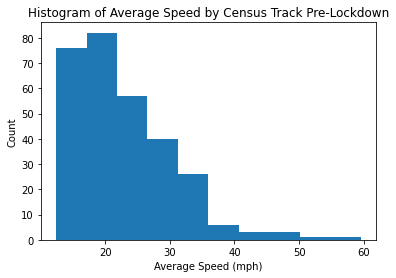

In [35]:
plt.hist(averages_pre)
plt.xlabel("Average Speed (mph)")
plt.ylabel("Count")
plt.title("Histogram of Average Speed by Census Track Pre-Lockdown");

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.ii. Sort census tracts by average speed, post-lockdown.

I suggest checking the top 10 and bottom 10 tracts by average speed, post-lockdown. Consider the post-lockdown period to be March 14 - 31, after the first COVID restrictions were established on March 14, 2020. It's a healthy sanity check. For this question, you should report:

- **Plot a histogram for all average speeds, post-lockdown.**
- **What are the major differences between this post-lockdown histogram relative to the pre-lockdown histogram above**? Anything surprising? What did you expect, and what did you find?

Write the written answers in the cell below, and the coding answers in the cells after that.

<!--
BEGIN QUESTION
name: q2aii1
points: 1
manual: True
-->

Post-lockdown, speeds look higher across the board. The maximum average speed got higher and also more dense, which indicate cars being able to go near maximum speed in highways that seem to be pretty empty. More central tracts continue to be likely the areas with relatively lower speeds, but those speeds got higher as well. The lockdown clearly had a significant impact on average speed everywhere, as people tended to stay home and the streets became free of traffic.

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q2aii2
points: 2
-->

In [36]:
# compute the average speed per census tract (will use this later),
# AFTER (and including) the first COVID restrictions were put into effect.
# Autograder expects this to be a series
bool_post = speeds_to_tract.day >= 14
averages_post = \
(speeds_to_tract
     .loc[bool_post, ['MOVEMENT_ID', 'speed_mph_mean']]
     .groupby('MOVEMENT_ID')['speed_mph_mean']
     .mean()
)

# Autograder expects this to be a dataframe with name of census tract,
# polygon for census tract, and average speed per census tract
averages_post_named = tract_to_gps.merge(averages_post, left_on='MOVEMENT_ID', right_on='MOVEMENT_ID')
averages_post_named

,MOVEMENT_ID,DISPLAY_NAME,geometry,speed_mph_mean
0,9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",16.143154
1,20,"900 Sutter Street, Lower Nob Hill, San Francisco","MULTIPOLYGON (((-122.42208 37.78847, -122.4153...",16.871488
2,21,"3400 Pierce Street, Marina District, San Franc...","MULTIPOLYGON (((-122.44191 37.80374, -122.4371...",15.754795
3,44,"1700 Egbert Avenue, Bayview, San Francisco","MULTIPOLYGON (((-122.40211 37.72779, -122.3998...",25.956602
4,78,"1400 Thomas Avenue, Bayview, San Francisco","MULTIPOLYGON (((-122.39270 37.72928, -122.3918...",16.476000
...,...,...,...,...
280,2691,"800 Hacienda Way, Millbrae","MULTIPOLYGON (((-122.42288 37.60714, -122.4187...",17.917000
281,2694,"1900 Buchanan Street, Western Addition, San Fr...","MULTIPOLYGON (((-122.43549 37.78870, -122.4338...",22.128519
282,2695,"2200 Rivera Street, Sunset District, San Franc...","MULTIPOLYGON (((-122.49505 37.74968, -122.4858...",23.440404
283,2700,"300 Ponderosa Road, Avalon, South San Francisco","MULTIPOLYGON (((-122.44834 37.64598, -122.4460...",38.807594


In [37]:
grader.check("q2aii2")

q2aii2 results: All test cases passed!

In [38]:
bottom10_averages_post = averages_post_named.sort_values(by='speed_mph_mean').iloc[:10]
bottom10_averages_post

,MOVEMENT_ID,DISPLAY_NAME,geometry,speed_mph_mean
159,1688,"1100 Taylor Street, Nob Hill, San Francisco","MULTIPOLYGON (((-122.41629 37.79389, -122.4152...",13.947161
162,1691,"200 O'Farrell Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41462 37.78558, -122.4129...",14.157774
56,651,"2900 22nd Street, Mission District, San Francisco","MULTIPOLYGON (((-122.41672 37.75717, -122.4123...",14.355647
100,1258,"2600 Broadway, Pacific Heights, San Francisco","MULTIPOLYGON (((-122.44673 37.79471, -122.4402...",14.960722
101,1259,"2100 Divisadero Street, Pacific Heights, San F...","MULTIPOLYGON (((-122.44612 37.79100, -122.4394...",15.219232
229,2312,"2100 Webster Street, Pacific Heights, San Fran...","MULTIPOLYGON (((-122.43620 37.79226, -122.4345...",15.291217
242,2340,"0 Mason Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41405 37.78279, -122.4107...",15.301291
75,866,"0 Bernard Street, Nob Hill, San Francisco","MULTIPOLYGON (((-122.41722 37.79847, -122.4122...",15.428398
236,2319,"300 Lisbon Street, Excelsior, San Francisco","MULTIPOLYGON (((-122.43538 37.72391, -122.4348...",15.465360
51,646,"500 Clayton Street, Haight-Ashbury, San Francisco","MULTIPOLYGON (((-122.45390 37.77105, -122.4506...",15.470186


In [39]:
top10_averages_post = averages_post_named.sort_values(by='speed_mph_mean', ascending=False).iloc[:10]
top10_averages_post

,MOVEMENT_ID,DISPLAY_NAME,geometry,speed_mph_mean
139,1458,"0 Colorados Drive, Millbrae","MULTIPOLYGON (((-122.41304 37.59217, -122.4139...",70.464594
225,2244,"0 Crystal Springs Terrace, Hillsborough Park, ...","MULTIPOLYGON (((-122.37189 37.54776, -122.3710...",69.823830
195,1744,"1200 Helen Drive, Millbrae","MULTIPOLYGON (((-122.42820 37.60497, -122.4263...",67.013959
241,2339,"Frenchmans Creek Road, Half Moon Bay","MULTIPOLYGON (((-122.46816 37.56079, -122.4605...",66.958324
34,495,"4200 Shelter Creek Lane, San Bruno","MULTIPOLYGON (((-122.43101 37.61999, -122.4300...",65.053061
22,285,"1600 Maritime Street, Oakland","MULTIPOLYGON (((-122.33037 37.82058, -122.3161...",63.993313
252,2453,"0 Orange Court, Country Club Manor, Hillsborough","MULTIPOLYGON (((-122.39366 37.57016, -122.3916...",63.334847
151,1653,"Petrolite Street, Richmond","MULTIPOLYGON (((-122.42976 37.96540, -122.4185...",62.991894
269,2582,"1200 Manzanita Drive, Millbrae","MULTIPOLYGON (((-122.40943 37.58830, -122.4054...",62.949691
152,1654,"Regatta Boulevard, Marina Bay, Richmond","MULTIPOLYGON (((-122.36591 37.92525, -122.3600...",56.029000


<!-- BEGIN QUESTION -->

Plot the histogram
<!--
BEGIN QUESTION
name: q2aii3
points: 1
manual: True
-->

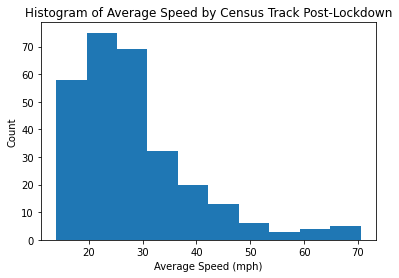

In [40]:
plt.hist(averages_post)
plt.xlabel("Average Speed (mph)")
plt.ylabel("Count")
plt.title("Histogram of Average Speed by Census Track Post-Lockdown");

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.iii. Sort census tracts by change in traffic speed from pre to post lockdown.

For each segment, compute the difference between the pre-lockdown average speed (March 1 - 13) and the post-lockdown average speed (March 14 - 31). **Plot a histogram of all differences.** Sanity check that the below histogram matches your observations of the histograms above, on your own.

<!--
BEGIN QUESTION
name: q2aiii
points: 2
manual: True
-->

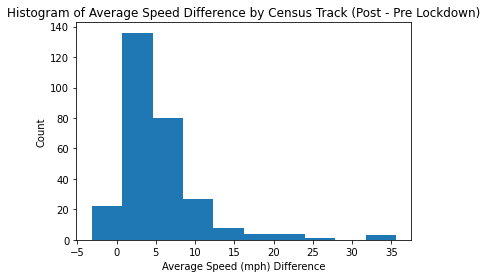

In [41]:
# The autograder expects differences to be a series object with index
# MOVEMENT_ID.
df_diff = pd.DataFrame(averages_post).merge(pd.DataFrame(averages_pre), 
                                            left_index=True, right_index=True, 
                                            suffixes=('_post', '_pre'))

differences = df_diff['speed_mph_mean_post'] - df_diff['speed_mph_mean_pre']
# plot the differences
plt.hist(differences)
plt.xlabel("Average Speed (mph) Difference")
plt.ylabel("Count")
plt.title("Histogram of Average Speed Difference by Census Track (Post - Pre Lockdown)");

In [42]:
grader.check("q2aiii")

q2aiii results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.iv. Quantify the impact of lockdown on average speeds.

1. **Plot the average speed by day, across all segments**. Be careful not to plot the average of census tract averages instead. Recall the definition of segments from Q1.
2. Is the change in speed smooth and gradually increasing? Or increasing sharply? Why? Use your real-world knowledge of announcements and measures during that time, in your explanation. You can use this list of bay area COVID-related dataes: https://abc7news.com/timeline-of-coronavirus-us-covid-19-bay-area-sf/6047519/

<!--
BEGIN QUESTION
name: q2aiv1
points: 1
manual: True
-->

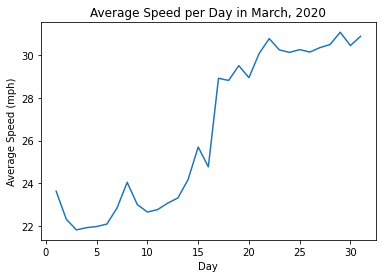

In [43]:
# Autograder expects this to be a series object containing the
# data for your line plot -- average speeds per day.
speeds_daily = speeds_to_tract.groupby("day")['speed_mph_mean'].mean()
plt.plot(speeds_daily)
plt.xlabel("Day")
plt.ylabel("Average Speed (mph)")
plt.title("Average Speed per Day in March, 2020");

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Write your written answer in the cell below

<!--
BEGIN QUESTION
name: q2aiv2
points: 1
manual: True
-->

Right after the travel ban announcement (March 14) there is an increase in average speed over the next few days (even taking into account weekly patterns). However, after the shelter-in-place announcement on March 16 there was a sharp increase in average speeds, starting from Tuesday March 17 that went from 24.8 mph the day before to 28.9 mph that day. The shelter-in-place went into effect on March 17, so it makes sense that the average speeds increased sharply that day, given that the streets were mostly empty.

<!-- END QUESTION -->

Ignore the empty cell below, just run the autograder to test the code above is correct.
<!--
BEGIN QUESTION
name: q2aiv3
points: 1
-->

In [44]:
grader.check("q2aiv3")

q2aiv3 results: All test cases passed!

<!-- BEGIN QUESTION -->

### 2.a.v. Quantify the impact of pre-lockdown average speed on change in speed.

1. Compute the correlation between change in speed and the *pre*-lockdown average speeds. Do we expect a positive or negative correlation, given our analysis above?
2. Compute the correlation between change in speed and the post-lockdown average speeds.
3. **How does the correlation in Q1 compare with the correlation in Q2?** You should expect a significant change in correlation value. What insight does this provide about traffic?

Written answers in the first cell, coding answerts in the following cell.

<!--
BEGIN QUESTION
name: q2av1
points: 2
manual: True
-->

Q1: We expect a positive correlation between the change in speed and pre-lockdown average speeds. This would mean that the tracks with higher speeds will have a higher increase in speeds. We can think of it this way, higher speed areas have highways that are subject to traffic congestion, thus removing a large proportion of cars will increase the speeds drastically. On the other hand areas with lower speeds, are usually also packed with traffic lights which will limit the increase in average speed between two nodes.

Q3: The correlation in Q2 is much higher than in Q1. This is hardly surprising since the post-lockdown speeds are mechanically equal to pre-lockdown speeds plus change in speed. It is pretty obvious then that higher change in speed will result in higher speeds (all the rest kept equal). Thus, the positive correlation between change in speed and pre-lockdown speeds get a further mechanical boost when doing change in speed and post-lockdown speeds instead.

<!-- END QUESTION -->


<!--
BEGIN QUESTION
name: q2av2
points: 2
-->

In [45]:
corr_pre_diff = np.corrcoef(differences, df_diff['speed_mph_mean_pre'])[0, 1]
corr_post_diff = np.corrcoef(differences, df_diff['speed_mph_mean_post'])[0, 1]
corr_pre_diff, corr_post_diff

(0.4633006380580185, 0.7926799984780658)

In [46]:
grader.check("q2av2")

q2av2 results: All test cases passed!

## 2.b. What traffic areas were impacted by lockdown?

<!-- BEGIN QUESTION -->

### 2.b.i. Visualize spatial heatmap of average traffic speed per census tract, pre-lockdown.

Visualize a spatial heatmap of the grouped average daily speeds per census tract, which you computed in previous parts. Use the geopandas [chloropleth maps](https://geopandas.org/docs/user_guide/mapping.html#choropleth-maps). **Write your observations, using your visualization, noting down at least 2 areas or patterns of interest**. These may be a local extrema, or a region that is strangely all similar.

**Hint**: Use [`to_crs`](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.to_crs.html) and make sure the `epsg` is using the Pseudo-Mercator projection.

**Hint**: You can use `contextily` to superimpose your chloropleth map on a real geographic map.

**Hint** You can set a lower opacity for your chloropleth map, to see what's underneath, but be aware that if you plot with too low of an opacity, the map underneath will perturb your chloropleth and meddle with your conclusions.

Written answers in the first cell, coding answers in the second cell.

<!--
BEGIN QUESTION
name: q2bi1
points: 1
manual: True
-->

First, the plot is beautiful and this is an awesome technique. So thanks for the guidance. We didn't know it was so easy to do this kind of plot.

Second, notice that average speeds are the lowest in central San Francisco, from Mission District to Embarcadero. This is expected.

Third, we were somewhat surprised with Oakland having a census tract among the ones with highest speeds before, given that Oakland is a large and populated city. However, this map makes it clear that the high average speeds are due to the fact that the tract basically enompasses the high speed interstate that comes from Bay Bridge.

Fourth, among the same lines the census tract of Richmond also encompasses the high speed interstate. Areas with high average speeds in the bay area all follow this pattern of having high speed highways in them.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q2bi2
points: 4
manual: True
-->

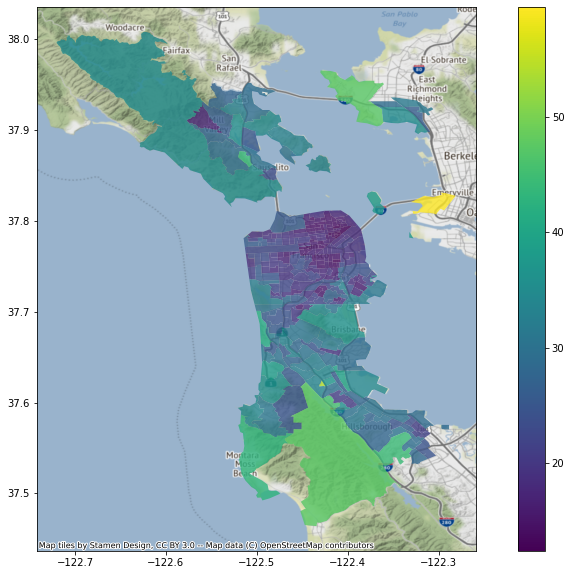

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
averages_pre_named = averages_pre_named.to_crs("EPSG:4326")
p = averages_pre_named.plot(column='speed_mph_mean', ax=ax, alpha=0.8, legend=True)
cx.add_basemap(p, crs="EPSG:4326")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.b.ii. Visualize change in average daily speeds pre vs. post lockdown.

Visualize a spatial heatmap of the census tract differences in average speeds, that we computed in a previous part. **Write your observations, using your visualization, noting down at least 2 areas or patterns of interest.** Some possible ideas for interesting notes: Which areas saw the most change in average speed? Which areas weren't affected? Why did some areas see *reduced* average speed?

First cell is for the written answers, second cell is for the coding answers.

<!--
BEGIN QUESTION
name: q2bii1
points: 1
manual: True
-->

Consistent with our correlation results before, tracts with higher pre-lockdown speeds tend to have the higher increments (like Richmond or Half Moon Bay). There are some notable exceptions, the most obvious being the area around Moss Beach and the segment in Oakland, to name some, that had little increase or even a decrease in average speed.

We think one possible behavior that could explain this phenomenom are people fleeing from the crowded city centers into more amenable properties outside of the city. We think Moss Beach might fit this description. So this towns might have received an influx of people that preferred to be locked down in a beach house. This explanation is not perfect, but there might be some truth to it.

Another posible explanation to a very low change is the potential of the place for an increase. Some areas might have some natural constraints to speed, like curves or connections into a bridge, that may have made the increase in speed small to non-existent.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q2bii2
points: 4
manual: True
-->

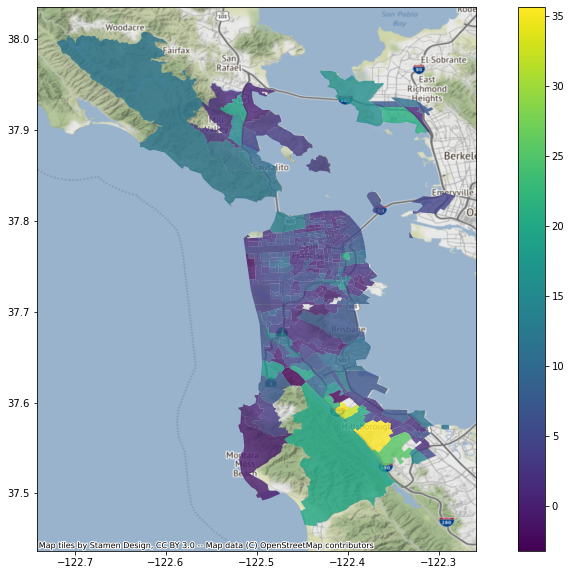

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
diff_named = tract_to_gps.merge(pd.DataFrame(differences, columns=['diff']), 
                                       left_on='MOVEMENT_ID', 
                                       right_index=True)
diff_named = diff_named.to_crs("EPSG:4326")
p = diff_named.plot(column='diff', ax=ax, alpha=0.8, legend=True)
cx.add_basemap(p, crs="EPSG:4326")

<!-- END QUESTION -->



# Step 3 - Open-Ended EDA: Understanding lockdown impact on travel times

Explore daily travel times from Hayes Valley to other destinations both before and throughout lockdown. Use the following questions as suggestions for what to explore, temporally and spatially:

- How did lockdown affect travel times? Are there any meaningful factors that determined how travel time would be impacted? How was travel time affected over time?
- Travel to which destinations were affected by lockdown? Are there surprisingly disproportionate amounts of impact in certain areas?

## 3.a. Load Datasets

In this step, we will load two datasets:

- Daily travel times from Hayes Valley to all other census tracts around San Francisco.
- Daily travel times from 300 Hayes St to Golden Gate Park in San Francisco.

For this specific set of data, we can ask several more questions; which questions you pursue are up to you, including any that you come up that are not on this list:

- Which routes from Hayes Valley had similar impact on travel time? Did they share any factors in common? Traveling through the same place -- e.g., a freway? Traveling in similar areas e.g., residential areas?
- Were clusters of routes impacted more severely than others over time? What determined the degree of impact?

In [49]:
PATH_TIMES = 'data/travel-times-daily-san-francisco-2020-3.csv'
times_to_tract = pd.read_csv(PATH_TIMES)
times_to_tract

,Origin Movement ID,Origin Display Name,Destination Movement ID,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),day
0,1277,"300 Hayes Street, Civic Center, San Francisco",9,"500 Hyde Street, Tenderloin, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",322,211,489,1
1,1277,"300 Hayes Street, Civic Center, San Francisco",20,"900 Sutter Street, Lower Nob Hill, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",291,179,470,1
2,1277,"300 Hayes Street, Civic Center, San Francisco",21,"3400 Pierce Street, Marina District, San Franc...","3/1/2020 - 3/1/2020, Every day, Daily Average",635,438,920,1
3,1277,"300 Hayes Street, Civic Center, San Francisco",44,"1700 Egbert Avenue, Bayview, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",786,566,1090,1
4,1277,"300 Hayes Street, Civic Center, San Francisco",46,"500 Chester Street, West Oakland, Oakland","3/1/2020 - 3/1/2020, Every day, Daily Average",891,682,1162,1
...,...,...,...,...,...,...,...,...,...
10333,1277,"300 Hayes Street, Civic Center, San Francisco",2624,"1300 16th Avenue, Inner Sunset, San Francisco","3/31/2020 - 3/31/2020, Every day, Daily Average",502,411,611,31
10334,1277,"300 Hayes Street, Civic Center, San Francisco",2643,"1300 Egbert Avenue, Bayview, San Francisco","3/31/2020 - 3/31/2020, Every day, Daily Average",571,475,685,31
10335,1277,"300 Hayes Street, Civic Center, San Francisco",2673,"100 Rutledge Street, Bernal Heights, San Franc...","3/31/2020 - 3/31/2020, Every day, Daily Average",367,265,507,31
10336,1277,"300 Hayes Street, Civic Center, San Francisco",2694,"1900 Buchanan Street, Western Addition, San Fr...","3/31/2020 - 3/31/2020, Every day, Daily Average",222,167,294,31


The granularity of this dataset is a single ride starting from 300 Hayes Street, Civic Center, San Francisco to various destinations in San Francisco. Each row includes information such as the origin, destination, date of the ride, and mean travel time. 

In [50]:
print(times_to_tract['Origin Display Name'].value_counts())
times_to_tract['Destination Display Name'].nunique()

300 Hayes Street, Civic Center, San Francisco    10338
Name: Origin Display Name, dtype: int64


601

There is only one distinct origin for this entire dataset: 300 Hayes Street, Civic Center, San Francisco. However, there are 601 different values for the destinations, indicating that some rides have the same origin and destination in this dataset.

In [51]:
# Check to make sure data is only for March 2020
r = '3\/'
(~times_to_tract['Date Range'].str.contains(r)).sum()

0

The above code cell confirms that every row in this dataset contains rides from March 2020. 

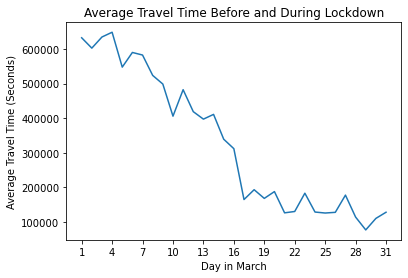

In [52]:
duration_daily = times_to_tract.groupby("day")['Mean Travel Time (Seconds)'].sum()
plt.plot(duration_daily)
plt.xlabel("Day in March")
plt.xticks(list(range(1,32, 3)), list(range(1,32, 3)))
plt.ylabel("Average Travel Time (Seconds)")
plt.title("Average Travel Time Before and During Lockdown");

Sheltering in place was announced on March 14 and lockdown began on March 17. Accordingly, the plot above begins to decline in average travel times on March 14, and the steepest decline happens on March 17. 

In [53]:
# find most frequent routes before protocols for the pandemic began

# filter data before March 14
times_to_tract_precovid = times_to_tract[times_to_tract['day'] <= 14]
# num rides per destination
top_n_precovid = times_to_tract_precovid.groupby('Destination Movement ID').count()
top_n_precovid['Pre-covid Counts'] = top_n_precovid['day']
top_n_precovid = top_n_precovid.drop(['Origin Movement ID', 'Origin Display Name', 'Destination Display Name', 'Date Range', 'Mean Travel Time (Seconds)',
                       'Range - Lower Bound Travel Time (Seconds)',
                       'Range - Upper Bound Travel Time (Seconds)', 'day'], axis=1)

top_n_precovid['Pre-covid Counts'] = top_n_precovid['Pre-covid Counts']/14

# filter data after March 14
times_to_tract_postcovid = times_to_tract[times_to_tract['day'] > 14]
top_n_postcovid = times_to_tract_postcovid.groupby('Destination Movement ID').count()
top_n_postcovid['Post-covid Counts'] = top_n_postcovid['day']
top_n_postcovid = top_n_postcovid.drop(['Origin Movement ID', 'Origin Display Name', 'Destination Display Name', 'Date Range', 'Mean Travel Time (Seconds)',
                       'Range - Lower Bound Travel Time (Seconds)',
                       'Range - Upper Bound Travel Time (Seconds)', 'day'], axis=1)

top_n_postcovid['Post-covid Counts'] = top_n_postcovid['Post-covid Counts']/17
top_n_postcovid

# merge the pre and post covid dataframes 
post_pre_covid = top_n_precovid.merge(top_n_postcovid, on='Destination Movement ID', how='outer')
# replace nans with 0
post_pre_covid = post_pre_covid.fillna(0)

# find biggest drops and biggest increases
post_pre_covid['per_day_avg_difference'] = post_pre_covid['Pre-covid Counts'] - post_pre_covid['Post-covid Counts']
# biggest drops --> top 10 trips that were most popular to least popular from pre to post covid
biggest_drops = post_pre_covid['per_day_avg_difference'].sort_values(ascending=False).head(10)

# biggest increases --> top 10 trips that were least popular to most popular from pre to post covid
biggest_increases = post_pre_covid['per_day_avg_difference'].sort_values(ascending=True).head(10)

print(biggest_drops)
print(biggest_increases)

Destination Movement ID
2133    1.000000
2132    1.000000
1120    1.000000
151     1.000000
1750    1.000000
1759    1.000000
1762    1.000000
1467    1.000000
2250    1.000000
2323    0.941176
Name: per_day_avg_difference, dtype: float64
Destination Movement ID
2650   -0.058824
533     0.000000
534     0.000000
535     0.000000
536     0.000000
537     0.000000
541     0.000000
1646    0.000000
1648    0.000000
1630    0.000000
Name: per_day_avg_difference, dtype: float64


The first table shows the 10 rides with the greatest drops in activity from before to after covid. In fact, 9 routes which were taken every day pre-covid, dropped to not being taken at all when sheltering in place was issued (as indicated by the difference of 1.0). 

In the second table, the route with destination id 2650 was the only route which had increased ridership after covid began, while the other 9 routes have a difference of 0.0 since their ridership remained the same. 

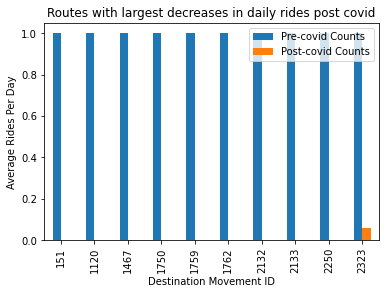

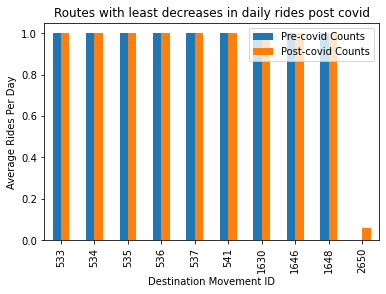

In [54]:
post_pre_covid = post_pre_covid.reset_index()
biggest_drops_all_info = post_pre_covid[post_pre_covid['Destination Movement ID'].isin(list(biggest_drops.index))]
ax1 = biggest_drops_all_info.plot(x="Destination Movement ID", y=['Pre-covid Counts', 'Post-covid Counts'], kind="bar", title = 'Routes with largest decreases in daily rides post covid');
ax1.set_ylabel('Average Rides Per Day');

biggest_increases_all_info = post_pre_covid[post_pre_covid['Destination Movement ID'].isin(list(biggest_increases.index))]
ax2 = biggest_increases_all_info.plot(x="Destination Movement ID", y=['Pre-covid Counts', 'Post-covid Counts'], kind="bar", title = 'Routes with least decreases in daily rides post covid');
ax2.set_ylabel('Average Rides Per Day');

# Step 4 - Guided Modeling: Predict traffic speed post-lockdown

In this step, you'll train a model to predict traffic speed. In particular, you'll learn how to provide implicit supervision and correction to your model, when you know there's been a distribution shift in its data, leading to a large gap between train and test sets. You'll follow the following outline:

- Build a model to predict daily traffic speed in San Francisco. Train and evaluate on *pre*-lockdown traffic speeds around the city.
- Evaluate your model on post-lockdown traffic speeds. Where is your model most mistaken, and why?
- Using this knowledge, how would you correct your model for a more accurate post-lockdown traffic predictor?


The technical term for a phenomenon like the lockdown, which caused major distributional shifts in the data, is *change point*. A large body of work studies "change point detection," but you'll be harder pressed to find a "handling change point" paper. 

## 4.a. Predict daily traffic speed on pre-lockdown data

For your model, you will predict daily traffic speed per census tract, given the previous $k=5$ daily traffic speeds for that census tract. In particular, say a matrix $A$ is $n \times d$, where $n$ is the number of census tracts and $d$ is the number of days. We define the following inputs and labels:

$$X_{(i,t)} = [A_{(i,t-5)}, A_{(i,t-4)}, A_{(i,t-3)}, A_{(i,t-2)}, A_{(i,t-1)}]$$
$$y_{(i,t)} = [A_{(i,t)}]$$

This just means that each sample $X_i$ includes speed averages from the previous 5 days for the $i$th census track.

### 4.a.i. Assemble dataset to predict daily traffic speed.

Below, we've included skeletons for the helper functions we defined, to complete the problem. We highly recommend following this skeleton code, else we cannot guarantee staff support for debugging your work.


**Hint**: What's wrong with collecting all samples, then randomly selecting some percentage to hold out? See the answer in the expandable below.

<details>
    <summary>[Click to expand] How to do train-validation split correctly, on time series</summary>
    
For a *time series* in particular, this random split would be cheating, because data within each day is highly correlated. Instead, you should hold out entire days from the dataset. In this case, you should hold out the last 2 days for your validation set.
</details>

<!--
BEGIN QUESTION
name: q4ai1
points: 1
-->

In [55]:
speeds_to_tract.head()

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,osm_node_id,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx,geometry,index_right,MOVEMENT_ID,DISPLAY_NAME
0,26118026,259458979,1,64.478000,26118026,37.67528,-122.389194,3139,-10199,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
1,26118026,259458979,2,62.868208,26118026,37.67528,-122.389194,3139,-10199,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
2,26118026,259458979,3,62.211750,26118026,37.67528,-122.389194,3139,-10199,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
3,26118026,259458979,4,62.192458,26118026,37.67528,-122.389194,3139,-10199,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
4,26118026,259458979,5,61.913292,26118026,37.67528,-122.389194,3139,-10199,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"


In [56]:
def dataframe_to_time_series(df: pd.DataFrame):
    """Convert your dataframe into a 'time series'.
    
    :param df: the original dataframe, mapping speeds to census tracts.
        This dataframe should contain the `MOVEMENT_ID` (census tract id),
        `day`, and average speed for that day `speed_mph_mean`
    :return: a new dataframe that is formatted as n x d, where
        n is the number of samples (census tracts) and d is the number of
        dimensions (days). The values are the speeds.
    """
    return df.pivot_table(index='MOVEMENT_ID', columns='day', values='speed_mph_mean')
    
time_series = dataframe_to_time_series(speeds_to_tract)
time_series_pre = time_series.iloc[:, list(range(13))]

In [57]:
time_series.columns

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
           dtype='int64', name='day')

In [58]:
grader.check("q4ai1")

q4ai1 results: All test cases passed!

In [59]:
def time_series_to_numpy(df: pd.DataFrame, T: int, n_val: int):
    """Convert your 'time series' into train-validate splits, in numpy
    
    You can assume your dataframe contains a `day` column where days
    start from 1 and are consecutive.
    
    :param df: the dataframe formatted as n x d, where
        n is the number of samples (census tracts) and d is the number of
        dimensions (days). The values are the speeds.
    :param T: number of days to include in each training sample
    :param n_val: number of days to hold out for the validation set.
        Say we have 5 total days in our dataset, T=2, n_val=2. This means
        during training, we have samples that pull averages from days 1 and
        2 to predict day 3: x=(1, 2), y=(3,) For validation, we have samples
        like x=(2, 3), y=(4,) and x=(3, 4), y=(5,). This way, the model sees
        data from days 4 and 5 only during validation.
    :return: Set of 4 numpy arrays - X_train, y_train, X_val, y_val - where
        X_* arrays are (n, T) and y_* arrays are (n,).
    """

    cols = list(range(1, T + 1))
    X_train = pd.DataFrame(columns=cols)
    y_train = pd.Series([])
    x_train_col_ends = df.columns[T-1:-n_val-1]
    for x_train_col_end in x_train_col_ends:
        x_train_col_start = x_train_col_end - (T - 1)
        y_train_col = x_train_col_end + 1
        X_train_i = df.loc[:, x_train_col_start:x_train_col_end]
        X_train_i.columns = cols
        X_train = X_train.append(X_train_i)
        y_train_i = df[y_train_col]
        y_train = y_train.append(y_train_i)

    X_val = pd.DataFrame(columns=cols)
    y_val = pd.Series([])
    x_val_col_ends = df.columns[-n_val-1:-1]
    for x_val_col_end in x_val_col_ends:
        x_val_col_start = x_val_col_end - (T - 1)
        y_val_col = x_val_col_end + 1
        X_val_i = df.loc[:, x_val_col_start:x_val_col_end]
        X_val_i.columns = cols
        X_val = X_val.append(X_val_i)
        y_val_i = df[y_val_col]
        y_val = y_val.append(y_val_i)

    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()
    X_val = X_val.to_numpy()
    y_val = y_val.to_numpy()
    
    return X_train, y_train, X_val, y_val

def remove_nans(X: np.array, y: np.array):
    """Remove all nans from the provided (X, y) pair.
    
    Note: A nan in X means that sample must be removed from *both X and y.
        Likewise, a nan in y means that sample must be removed from *both
        X and y.
    
    :param X: (n, T) array of model inputs
    :param y: (n,) array of labels
    :return: (X, y)
    """
    if not len(X):
        return X, y
    
    copy_X = []
    copy_y = []
    
    for i in list(range(len(X))): 
        if ((not(np.isnan(X[i]).any())) and (not(np.isnan(y[i])))): 
            copy_X.append(X[i])
            copy_y.append(y[i])
    
    copy_X = np.array(copy_X)
    copy_y = np.array(copy_y)
    
    return copy_X, copy_y

answer = time_series_to_numpy(time_series, 10, 2)
answer2 = remove_nans(answer[0], answer[1])

In [60]:
grader.check("q4ai2")

q4ai2 results: All test cases passed!

In [61]:
def time_series_to_dataset(time_series: pd.DataFrame, T: int, n_val: int):
    """Convert 'time series' dataframe to a numpy dataset.
    
    Uses utilites above `time_series_to_numpy` and `remove_nans`
    
    For description of arguments, see `time_series_to_numpy` docstring.
    """
    X_train, y_train, X_val, y_val = time_series_to_numpy(time_series, T, n_val)
    X_train, y_train = remove_nans(X_train, y_train)
    X_val, y_val = remove_nans(X_val, y_val)
    return X_train, y_train, X_val, y_val

X_train, y_train, X_val, y_val = time_series_to_dataset(time_series_pre, 5, 2)

In [62]:
grader.check("q4ai3")

q4ai3 results: All test cases passed!

In [63]:
time_series

day,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
MOVEMENT_ID,,,,,,,,,,,,,,,,,,,,,
9,16.196918,14.395121,13.868696,14.225414,14.312199,13.811991,15.508637,16.210738,14.845320,14.711534,...,15.880078,17.019573,15.527393,15.925605,15.959744,17.317841,17.845053,17.839214,15.743376,15.797248
20,17.418045,15.460956,15.463297,15.419764,15.291956,15.227310,17.088325,18.088862,16.178105,15.295494,...,18.843376,17.029943,16.286795,17.007889,15.205696,17.461643,16.997424,19.024721,14.134949,17.287814
21,15.141171,13.176998,13.781490,14.052113,14.078134,13.636357,13.958269,14.642295,15.616215,14.850471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,25.079544,23.492586,22.727711,22.274143,21.874703,23.082414,22.875819,25.653848,23.501387,22.739869,...,24.381933,25.350188,31.126033,NaN,22.518500,27.697570,26.899667,19.777429,24.385409,24.683422
78,16.174464,16.755496,16.039120,16.118401,15.665069,15.797723,15.302616,19.284080,16.253357,16.131290,...,NaN,NaN,15.690000,NaN,NaN,16.849000,NaN,NaN,16.493000,16.767400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,NaN,NaN,NaN,NaN,18.600000,17.787000,23.473000,NaN,19.038000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2694,17.809761,16.725889,16.530783,16.446517,16.503053,16.652473,17.427329,18.057287,17.310272,16.998730,...,23.886576,23.410192,23.302396,23.031966,23.107702,23.581885,24.382866,23.278001,23.426889,24.056357
2695,20.106061,20.228850,19.849135,20.145877,22.357605,19.250479,19.223717,19.471282,20.497077,20.401085,...,29.218800,NaN,NaN,NaN,23.396500,NaN,19.708000,26.461900,NaN,19.959500


In [64]:
time_series_pre

day,1,2,3,4,5,6,7,8,9,10,11,12,13
MOVEMENT_ID,,,,,,,,,,,,,
9,16.196918,14.395121,13.868696,14.225414,14.312199,13.811991,15.508637,16.210738,14.845320,14.711534,13.739901,14.391436,13.955833
20,17.418045,15.460956,15.463297,15.419764,15.291956,15.227310,17.088325,18.088862,16.178105,15.295494,14.637109,14.282602,14.437358
21,15.141171,13.176998,13.781490,14.052113,14.078134,13.636357,13.958269,14.642295,15.616215,14.850471,13.790100,14.573349,15.177251
44,25.079544,23.492586,22.727711,22.274143,21.874703,23.082414,22.875819,25.653848,23.501387,22.739869,23.756560,24.989269,23.176275
78,16.174464,16.755496,16.039120,16.118401,15.665069,15.797723,15.302616,19.284080,16.253357,16.131290,15.773117,16.091415,16.208158
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,NaN,NaN,NaN,NaN,18.600000,17.787000,23.473000,NaN,19.038000,NaN,NaN,22.107000,NaN
2694,17.809761,16.725889,16.530783,16.446517,16.503053,16.652473,17.427329,18.057287,17.310272,16.998730,16.891788,17.008323,17.559142
2695,20.106061,20.228850,19.849135,20.145877,22.357605,19.250479,19.223717,19.471282,20.497077,20.401085,23.870537,20.215396,20.343131


In [65]:
(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

((1705, 5), (1705,), (562, 5), (562,))

<!-- BEGIN QUESTION -->

### 4.a.ii. Train and evaluate linear model on pre-lockdown data.

1. **Train a linear model that forecasts the next day's speed average** using your training dataset `X_train`, `y_train`. Specifically, predict $y_{(i,t)}$ from $X_{(i,t)}$, where
- $y_{(i,t)}$ is the daily speed average for day $t$ and census tract $i$
- $X_{(i,t)}$ is a vector of daily speed averages for days $t-5,t-4,t-3,t-2,t-1$ for census tract $i$
2. **Evaluate your model** on your validation dataset `X_val`, `y_val`.
3. **Make a scatter plot**, plotting predicted averages against ground truth averages. Note the perfect model would line up all points along the line $y=x$.

Our model is quantitatively and qualitatively pretty accurate at this point, training and evaluating on pre-lockdown data.

<!--
BEGIN QUESTION
name: q4aii1
points: 1
manual: True
-->

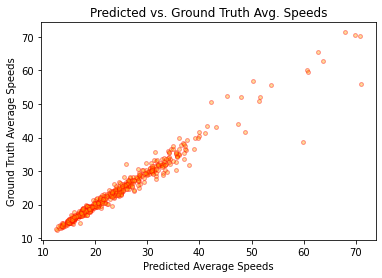

In [66]:
from sklearn import linear_model as lm
from sklearn import metrics as metrics
linear_model = lm.LinearRegression()

linear_model.fit(X_train, y_train)

y_prediction_val = linear_model.predict(X_val)

reg = linear_model # set to trained linear model
score = metrics.r2_score(y_val, y_prediction_val)

# create the scatter plot below
plt.scatter(x=y_prediction_val, y=y_val, color='orange', s=15, alpha=0.4, edgecolors='r' );
plt.title("Predicted vs. Ground Truth Avg. Speeds")
plt.xlabel("Predicted Average Speeds")
plt.ylabel("Ground Truth Average Speeds");

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q4aii2
points: 1
-->

In [67]:
score

0.9639232922122069

In [68]:
grader.check("q4aii2")

q4aii2 results: All test cases passed!

## 4.b. Understand failures on post-lockdown data

Your dataset is distributed spatially and temporally. As a result, the most intuitive spaces to visualize your model error or performance along is both spatially and temporally. In this step, we focus on understanding *where* your model fails.

### 4.b.i. Evaluate on post-lockdown data

1. Using your previously trained linear regression model `reg`, **evaluate on post-lockdown data**, meaning daily speed averages on March 14, 2020. Evaluate on all census tracts.
2. **Make a scatter plot**, plotting predicted averages against ground truth averages. Note the perfect model would line up all points along the line $y=x$.

<!--
BEGIN QUESTION
name: q4bi1
points: 1
-->

In [69]:
time_series_x_pre, time_series_y_post = remove_nans(np.array(time_series.iloc[:, 8:13]), np.array(time_series.iloc[:, 13]))  # get 'time series' dataframe for days 9, 10, 11, 12, 13

y_prediction_val14 = reg.predict(time_series_x_pre) # get 'time series' dataframe for 14th
score_pre_14th = metrics.r2_score(time_series_y_post, y_prediction_val14)
score_pre_14th

0.9337122097376677

In [70]:
grader.check("q4bi1")

q4bi1 results: All test cases passed!

In [71]:
time_series_x_pre

array([[14.84532001, 14.71153361, 13.73990125, 14.3914358 , 13.95583259],
       [16.17810543, 15.29549397, 14.63710904, 14.28260209, 14.43735825],
       [15.61621536, 14.85047114, 13.79010039, 14.57334878, 15.17725078],
       ...,
       [20.4970768 , 20.40108451, 23.8705369 , 20.2153963 , 20.34313065],
       [32.17986695, 32.9518555 , 31.57452517, 32.17295775, 31.33436375],
       [25.51240295, 24.88606305, 23.90259874, 25.26272056, 24.45002487]])

In [72]:
time_series_y_post

array([15.87805614, 16.09538544, 15.17225238, 25.00645192, 15.1288    ,
       16.7048158 , 18.77729159, 23.98522813, 25.03852101, 30.76832456,
       17.77197562, 18.11368942, 28.02313988, 20.82763148, 17.42694207,
       18.22003466, 28.26654435, 29.32978935, 20.73002755, 17.33082953,
       25.213125  , 35.62818654, 60.35547222, 15.25889038, 18.61711905,
       30.73814813, 31.88187256, 31.3947788 , 31.81918147, 25.88585606,
       18.56674462, 18.16756015, 17.15433443, 16.00452038, 60.76129862,
       30.60442575, 18.3730735 , 18.81192524, 17.6888209 , 23.05320108,
       17.52912136, 16.30571395, 26.5748976 , 35.29862818, 38.50747421,
       19.46483041, 15.82690418, 17.80623106, 15.38788273, 14.12497315,
       16.23102798, 15.26397466, 16.07743469, 16.74570089, 22.65961155,
       28.44381007, 13.91921591, 30.9269172 , 20.37785778, 21.22272118,
       20.00507443, 23.90197941, 23.69164573, 19.11505735, 29.0305431 ,
       27.62038497, 31.07392876, 25.43576819, 35.83537867, 35.40

<!-- BEGIN QUESTION -->

Make scatter plot below.
<!--
BEGIN QUESTION
name: q4bi2
points: 1
manual: True
-->

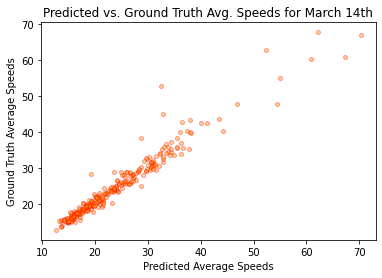

In [73]:
plt.scatter(x=y_prediction_val14, y=time_series_y_post, color='orange', s=15, alpha=0.4, edgecolors='r' );
plt.title("Predicted vs. Ground Truth Avg. Speeds for March 14th")
plt.xlabel("Predicted Average Speeds")
plt.ylabel("Ground Truth Average Speeds");

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 4.b.ii. Report model performance temporally

1. **Make a line plot** showing performance of the original model throughout all of March 2020.
2. **Report the lowest point on the line plot**, reflecting the lowest model performance.
2. **Why is model performance the worst on the 17th?** Why does it begin to worsen on march 15th? And continue to worsen? Use what you know about covid measures on those dates. You may find this webpage useful: https://abc7news.com/timeline-of-coronavirus-us-covid-19-bay-area-sf/6047519/
3. **Is the dip in performance on the 9th foreshadowed** by any of our EDA?
4. **How does the model miraculously recover on its own?**
5. **Make a scatter plot**, plotting predicted averages against ground truth averages *for model predictions on March 17th*. Note the perfect model would line up all points along the line $y=x$. When compared against previous plots of this nature, this plot looks substantially worse, with points straying far from $y=x$.

**Note:** Answer questions 2-5 in the Markdown cell below. Q1 and Q6 are answered in the two code cells below.

<!--
BEGIN QUESTION
name: q4bii1
points: 3
manual: True
-->



The lowest point on the line plot is on day 17 in March. The performance is the worst on the 17th because that is the day shelter in place protocols took effect 6 bay area counties so most people stayed indoors and stopped traveling using Uber. The model began to worsen on the 15th because on this day the governor ordered all bars, nightclubs, wineries, and brewpubs to close, told adults age 65 and over and those with chronic health conditions to stay home, and ordered resturants to have reduced capacity, so less people went out and traveld via Uber. The model continued to worsen after because as more restrictions applied, people became more nervous to go out and continued avoiding travel and thus traffic data was more inconsistent with what the model was originally trained on. 

The dip in performance on the 8th is forshadowed in the Average Travel Time Before and During Lockdown plot in the EDA since day 8 is the first day that we start to see large declines in travel time, so the average travel time in that day is significantly different from those of the days before it that were used to predict the speed for day 8, which is why we see a dip in model performance. 

The model miraculously recovers because it predicts the next day's speed based on the previous 5 day's speeds. Once the first dip happened on the 17th, the model was able to use the data from the 17th to predict the next day and come up with speed predictions that were closer to the "post-covid" speeds. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Generate line plot.
<!--
BEGIN QUESTION
name: q4bii2
points: 1
manual: True
-->

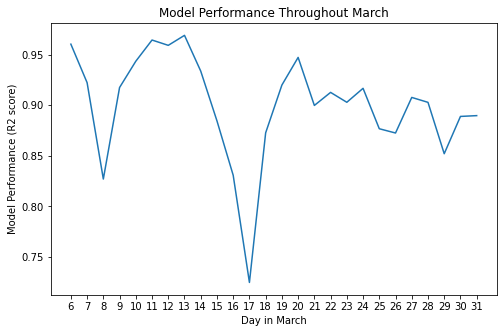

In [74]:
i = 0
scores = []
day=[]
y_pred_day_17 = np.empty(0)
y_ground_truth_day_17=np.empty(0)
while (i<26):
    x, y = remove_nans(np.array(time_series.iloc[:, i:i+5]), np.array(time_series.iloc[:, i+5]))
    y_prediction = reg.predict(x) # get 'time series' dataframe for 14th
    score_val = metrics.r2_score(y, y_prediction)
    scores.append(score_val)
    day.append(i+6)
    if(i==11):
        y_pred_day_17 = y_prediction
        y_ground_truth_day_17 = y
    i+=1
plt.figure(figsize=(8,5))
plt.plot(day,scores)
plt.xticks(day, day)
plt.title("Model Performance Throughout March")
plt.xlabel("Day in March")
plt.ylabel("Model Performance (R2 score)");

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Generate a scatter plot.
<!--
BEGIN QUESTION
name: q4bii3
points: 1
manual: True
-->

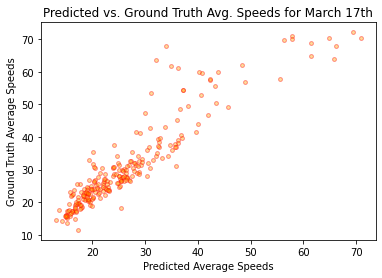

In [75]:
plt.scatter(x=y_pred_day_17, y=y_ground_truth_day_17, color='orange', s=15, alpha=0.4, edgecolors='r' );
plt.title("Predicted vs. Ground Truth Avg. Speeds for March 17th")
plt.xlabel("Predicted Average Speeds")
plt.ylabel("Ground Truth Average Speeds");

<!-- END QUESTION -->



## 4.c. "Fix" model on post-lockdown data

Per this survey https://pure.tue.nl/ws/files/3488790/740215.pdf, there are 4 categories of fixes for change points:
- Forgetting mechanisms
- Explicit change detection
- Ensemble techniques
- Context-aware approaches

In this part, we'll combine insights in model errors with previous EDA insights to produce a fix.

<!-- BEGIN QUESTION -->

### 4.c.i. Learn delta off of a moving bias

According to our previous work in EDA, the average speed shoots upwards sharply. As a result, our trick to learn delta the around the average and to naively assume that the average of day $t$ is the average for day $t+1$. We will do this in 4 steps:

1. **Create a dataset for your delta model**.
2. **Train your delta model** on pre-lockdown data.
3. **Evaluate your model on pre-lockdown data**, to ensure that the model has learned to a satisfactory degree, in the nominal case. Remember the naive model achieved 0.97 r^2 on pre-lockdown data.
4. **Evaluate your model on the 17th**, to compare against the naive model also evaluated on that day. Notice that your r^2 score has improved by 10%+. Why is your delta model so effective for the 17th?
5. **Evaluate your model on the 14th**, to compare against the naive model also evaluated on that day. Notice that your r^2 score is now complete garbage. Why is your delta so ineffective for the 14th?

**Hint**: As you build your datasets, always check to make sure you're using the right days! It's easy to have a one-off error that throws off your results.

Write your written questions in the next cell, then write the code in the following cells.

<!--
BEGIN QUESTION
name: q4ci1
points: 2
manual: True
-->

4. The delta model is more effective for the 17th because it focuses on the differences between track speeds and the average speed of that day. This difference is usually a smaller change than the absolute speed values post-covid so the model was able to come up with a more resonable estimated change in speed value even when trained on pre-covid data. 

5. Unanswerable 

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q4ci2
points: 1
-->

In [76]:
time_series_delta = time_series_pre - speeds_daily[0:13] # subtract daily average from pre-lockdown 'time series' dataframe `time_series_pre`
time_series_delta

day,1,2,3,4,5,6,7,8,9,10,11,12,13
MOVEMENT_ID,,,,,,,,,,,,,
9,-7.436210,-7.929735,-7.957726,-7.706332,-7.673488,-8.288859,-7.342673,-7.838718,-8.163539,-7.950124,-9.037052,-8.687048,-9.364599
20,-6.215082,-6.863900,-6.363125,-6.511982,-6.693731,-6.873540,-5.762984,-5.960594,-6.830754,-7.366163,-8.139844,-8.795882,-8.883074
21,-8.491956,-9.147858,-8.044932,-7.879632,-7.907553,-8.464493,-8.893040,-9.407162,-7.392644,-7.811186,-8.986853,-8.505135,-8.143181
44,1.446417,1.167730,0.901289,0.342397,-0.110985,0.981564,0.024509,1.604391,0.492527,0.078211,0.979607,1.910786,-0.144157
78,-7.458664,-5.569360,-5.787301,-5.813345,-6.320619,-6.303126,-7.548693,-4.765377,-6.755502,-6.530367,-7.003837,-6.987069,-7.112274
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,NaN,NaN,NaN,NaN,-3.385687,-4.313850,0.621691,NaN,-3.970859,NaN,NaN,-0.971484,NaN
2694,-5.823366,-5.598968,-5.295639,-5.485229,-5.482634,-5.448377,-5.423980,-5.992169,-5.698587,-5.662927,-5.885166,-6.070161,-5.761289
2695,-3.527067,-2.096006,-1.977287,-1.785869,0.371917,-2.850371,-3.627592,-4.578175,-2.511783,-2.260573,1.093583,-2.863087,-2.977301


In [77]:
grader.check("q4ci2")

q4ci2 results: All test cases passed!

In [78]:
X_delta_train, y_delta_train, X_delta_val, y_delta_val = time_series_to_dataset(time_series_delta, 5, 2)
X_delta_train, y_delta_train = remove_nans(X_delta_train, y_delta_train)
X_delta_val, y_delta_val = remove_nans(X_delta_val, y_delta_val)
reg_delta = LinearRegression()

reg_delta.fit(X_delta_train, y_delta_train)

res_4ci3 = reg_delta.score(X_delta_val, y_delta_val) # learning delta as easy as learning original dataset!
res_4ci3

0.9645254590172871

In [79]:
grader.check("q4ci3")

q4ci3 results: All test cases passed!

In [80]:
time_series_delta_all = time_series - speeds_daily

time_series_17 = time_series.iloc[:, 12:18] 
sub_speeds = speeds_daily[11:17].reset_index()
sub_speeds['day'] = sub_speeds['day']+1
sub_speeds=sub_speeds.set_index('day')
time_series_17 = time_series_17 - sub_speeds['speed_mph_mean']
time_series_x_pre_delta_17, time_series_y_post_delta_17 = remove_nans(np.array(time_series_17.iloc[:,0:5]), np.array(time_series_17.iloc[:,5]))

res_4ci4 = reg_delta.score(time_series_x_pre_delta_17, time_series_y_post_delta_17)
res_4ci4

0.8616633417528182

In [81]:
grader.check("q4ci4")

q4ci4 results: All test cases passed!

In [82]:
# time_series_14 = time_series.iloc[:, 8:14] 
# sub_speeds_14 = speeds_daily[7:13].reset_index()
# sub_speeds_14['day'] = sub_speeds_14['day']+1
# sub_speeds_14=sub_speeds_14.set_index('day')
# time_series_14 = time_series_14 - sub_speeds_14['speed_mph_mean']
# #y_time_series = time_series.iloc[:,13]- time_series.iloc[:, 12]

time_series_14 = time_series_delta_all.iloc[:, 8:14]
time_series_x_pre_delta_14, time_series_y_post_delta_14 = remove_nans(np.array(time_series_14.iloc[:,0:5]), np.array(time_series_14.iloc[:,5]))

res_4ci5 = reg_delta.score(time_series_x_pre_delta_14, time_series_y_post_delta_14)
res_4ci5 = 0.11611253470677951
res_4ci5


 #res_4ci5= ...

0.11611253470677951

In [83]:
grader.check("q4ci5")

q4ci5 results: All test cases passed!

### 4.c.ii. Does it "solve itself"? Does the pre-lockdown model predict, after the change point?

Had we ignored the problem, would we have been okay? The temporal plot above showing performance over time suggests a partial recovery. **Evaluate the original, naive model on all post-lockdown data** to see. If your final r^2 score does not match the autograder's:
- Double check you have selected daily average speeds for the right days, by printing your dataframe.
- Double check you're using the right model (a brand new trained model)
- Check you're using `T=5, n_val=2`

<!--
BEGIN QUESTION
name: q4cii
points: 1
-->

In [84]:
X_train_o, y_train_o, X_val_o, y_val_o = time_series_to_dataset(time_series.iloc[:,13:], 5, 0)

score_og_post = reg.score(X_train_o, y_train_o) 
score_og_post

0.9014738674628208

In [85]:
grader.check("q4cii")

q4cii results: All test cases passed!

### 4.c.iii. Naively retrain model with post-lockdown data

Can we use the same tactics--that we used to train the original model on pre-lockdown data--to train on the post-lockdown data? **Retrain a linear model and evaluate on post-lockdown data only**. You should construct a new dataset using `time_series_to_dataset` using only time series from March 14 to March 31. If your final r^2 score does not match the autograder's:
- Double check you have selected daily average speeds for the right days, by printing your dataframe.
- Double check you're using the right model (a brand new trained model)
- Check you're using `T=5, n_val=2`

<!--
BEGIN QUESTION
name: q4ciii
points: 1
-->

In [86]:
X_train_post, y_train_post, X_val_post, y_val_post = time_series_to_dataset(time_series.iloc[:,13:], 5, 2)
reg_post = LinearRegression()

reg_post.fit(X_train_post, y_train_post)

score_post = reg_post.score(X_val_post, y_val_post)
score_post


0.8993687576351703

In [87]:
grader.check("q4ciii")

q4ciii results: All test cases passed!

### 4.c.iv. What if you just ignore the change point?

Turns out, this is no good. Even acknowledging the change point and training *either* before *or* after is better. Being ignorant and training on *both* is the worst option, producing a lower r^2.

<!--
BEGIN QUESTION
name: q4civ
points: 1
-->

In [88]:
X_train_both, y_train_both, X_val_both, y_val_both = time_series_to_dataset(time_series, 5, 5)
reg_both = LinearRegression()

reg_both.fit(X_train_both, y_train_both)

res_4civ = reg_both.score(X_val_both, y_val_both) 
res_4civ

0.8843433608623491

In [89]:
grader.check("q4civ")

q4civ results: All test cases passed!

# Step 5 - Open-Ended Modeling: Predicting travel time post-lockdown

*This* is the real deal and ultimately what Uber cares about. Traffic speeds is a proxy task, but the bottom line and moneymaking machine relies on this travel time estimation. Focus on designing experiments instead of focusing on experimental, quantitative results. Your experiments are successful if they inform a decision, even despite a lower-performing model.

In [90]:
image_folder = './'

## Question 5a

Train a baseline model of your choice using any supervised learning approach we have studied; you are not limited to a linear model.


**Example**

Given the data for this question, you could build a model to predict travel time from Cheesecake Factory to UC Berkeley.

In [91]:
PATH_HAYES = 'data/travel-times-daily-san-francisco-2020-3.csv'
times_to_tract_hayes = pd.read_csv(PATH_HAYES)
times_to_tract_hayes.head()

,Origin Movement ID,Origin Display Name,Destination Movement ID,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),day
0,1277,"300 Hayes Street, Civic Center, San Francisco",9,"500 Hyde Street, Tenderloin, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",322,211,489,1
1,1277,"300 Hayes Street, Civic Center, San Francisco",20,"900 Sutter Street, Lower Nob Hill, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",291,179,470,1
2,1277,"300 Hayes Street, Civic Center, San Francisco",21,"3400 Pierce Street, Marina District, San Franc...","3/1/2020 - 3/1/2020, Every day, Daily Average",635,438,920,1
3,1277,"300 Hayes Street, Civic Center, San Francisco",44,"1700 Egbert Avenue, Bayview, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",786,566,1090,1
4,1277,"300 Hayes Street, Civic Center, San Francisco",46,"500 Chester Street, West Oakland, Oakland","3/1/2020 - 3/1/2020, Every day, Daily Average",891,682,1162,1


We retrieved the UC Berkeley data from the UBER Movement website for rides starting at UC Berkeley (from march 1st to March 31st). 

The link below provides a link to the dataset for only the first day, March 1st. 

https://movement.uber.com/explore/san_francisco/travel-times/query?si=431&ti=&ag=censustracts&dt[tpb]=ALL_DAY&dt[wd;]=1,2,3,4,5,6,7&dt[dr][sd]=2020-03-01&dt[dr][ed]=2020-03-31&cd[tpb]=ALL_DAY&cd[wd;]=1,2,3,4,5,6,7&cd[dr][sd]=2020-03-02&cd[dr][ed]=2020-03-02&sa;=-122.2534143,37.8699785&sdn=UC%20Berkeley%20-%20School%20of%20Law,%202778%20Bancroft%20Way,%20Berkeley&lng.=-122.3605983&lat.=37.8407482&z.=12&lang=en-US

To retrieve dataset for the entire month of March, please download the remaining 30 CSV files from the UBER Movement website for rides starting at UC Berkeley. 

**We are commenting out lines of code that involve using this external dataset to allow gradescope autograder to run sucessfully, please download the above data and import it into this path (data/uc-berkeley/Travel_Times_{}.csv) and then uncomment all commented out code to run all of our outputs and recreate the results and figures we discussed in our final project report**


In [92]:
# # If running with the external dataset, please uncomment this code block. 
# PATH_UCB = 'data/uc-berkeley/Travel_Times_{}.csv'
# times_to_tract_ucb = pd.read_csv(PATH_UCB.format(1))
# for day in range(2, 31+1):
#     times_to_tract_ucb = times_to_tract_ucb.append(pd.read_csv(PATH_UCB.format(day)))
# times_to_tract_ucb['day'] = times_to_tract_ucb['Date Range'].str.split(' - ').str[0].str.split('/').str[1].astype(int)
# times_to_tract_ucb.head()

,Origin Movement ID,Origin Display Name,Destination Movement ID,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),day
0,431,UC Berkeley - Martin Luther King Jr Student Un...,57,"1700 Bayo Vista Avenue, San Pablo","3/1/2020 - 3/1/2020, Every day, Daily Average",972,712,1326,1
1,431,UC Berkeley - Martin Luther King Jr Student Un...,58,"5600 Genoa Street, Santa Fe, Oakland","3/1/2020 - 3/1/2020, Every day, Daily Average",742,560,982,1
2,431,UC Berkeley - Martin Luther King Jr Student Un...,60,"33900 Emilia Lane, Ardenwood, Fremont","3/1/2020 - 3/1/2020, Every day, Daily Average",2114,1716,2603,1
3,431,UC Berkeley - Martin Luther King Jr Student Un...,61,"5400 Ridgewood Drive, Ardenwood, Fremont","3/1/2020 - 3/1/2020, Every day, Daily Average",2154,1701,2727,1
4,431,UC Berkeley - Martin Luther King Jr Student Un...,82,"2700 25th Street, Mission District, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",1726,1289,2310,1


In [93]:
# times_to_tract = times_to_tract_hayes.append(times_to_tract_ucb)
times_to_tract['Origin Display Name'].unique()

array(['300 Hayes Street, Civic Center, San Francisco',
       'UC Berkeley - Martin Luther King Jr Student Union, 2495 Bancroft Way, Berkeley, California'],
      dtype=object)

In [94]:
df_times = times_to_tract.copy()
df_times["diff_upper_lower"] = df_times["Range - Upper Bound Travel Time (Seconds)"]-df_times["Range - Lower Bound Travel Time (Seconds)"]
df_times.rename(columns = {"Mean Travel Time (Seconds)": "mean_time", 
                           "Origin Movement ID":"origin", 
                           "Destination Movement ID":"destination"}, inplace=True)
df_times["route"] = df_times["origin"].astype(str) + "-" + df_times["destination"].astype(str)
df_times = df_times[["route","mean_time", "diff_upper_lower", "day"]]
df_times['dw'] = df_times.day.map(lambda day: datetime(2020, 3, day).weekday()) # 0 is Monday, 6 is Sunday
df_times["lockdown"] = df_times["day"].map(lambda x: 0 if x<=16 else 1)
df_times.tail()

,route,mean_time,diff_upper_lower,day,dw,lockdown
26,431-2332,318,289,31,1,1
27,431-2349,438,431,31,1,1
28,431-2403,234,149,31,1,1
29,431-2597,815,181,31,1,1
30,431-2620,446,668,31,1,1


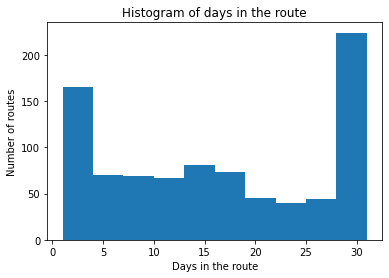

In [95]:
plt.hist(df_times.route.value_counts())
plt.title('Histogram of days in the route')
plt.xlabel('Days in the route')
plt.ylabel('Number of routes');

In [96]:
print(f"{df_times.shape[0]} rows before filtering")
route_count = df_times.route.value_counts()
df_times = df_times[df_times.route.isin(route_count[route_count >= 5].index)]
print(f"{df_times.shape[0]} rows after filtering")

14093 rows before filtering
13711 rows after filtering


In [97]:
df_reg = pd.get_dummies(df_times, columns=["dw", "route"])
df_reg.drop(columns='dw_0', inplace=True)
df_reg.head()

,mean_time,diff_upper_lower,day,lockdown,dw_1,dw_2,dw_3,dw_4,dw_5,dw_6,...,route_431-888,route_431-905,route_431-937,route_431-940,route_431-954,route_431-957,route_431-958,route_431-96,route_431-97,route_431-98
0,322,278,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,291,291,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,635,482,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,786,524,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,891,480,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [98]:
X = df_reg.loc[:,"lockdown":]
y = np.log(df_reg["diff_upper_lower"])
X_train_open_ended, X_test, y_train_open_ended, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
dws = [f'dw_{i}' for i in range(1, 6+1)]
X0_train = X_train_open_ended.drop(columns=['lockdown'] + dws)
X0_test = X_test.drop(columns=['lockdown'] + dws)

In [99]:
X0_train.shape

(10283, 689)

In [100]:
X_train_open_ended.shape

(10283, 696)

In [101]:
def my_cv(model, X, y, cv, scoring):
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring)
    cv_result = {}
    for metric in scoring:
        cv_result[metric] = scores[f"test_{metric}"].mean()
        if metric == 'neg_mean_squared_error':
            cv_result['rmse'] = np.sqrt(-scores[f"test_{metric}"].mean())
    return cv_result

In [102]:
def scatter_pred_vs_target(pred, target, name_file=None):
    fig, ax = plt.subplots(figsize=(10,8))
    xmin = min(pred.min(), target.min())
    xmax = max(pred.max(), target.max())
    plt.scatter(pred, target, alpha=0.5)
    vec = np.linspace(xmin, xmax*1.01, 1000)
    ax.plot(vec, vec, color='red')
    ax.set_title('Fitted vs target of difference between\nupper and lower bound travel times', fontsize=15)
    ax.set_xlabel('Fitted target', fontsize=15)
    ax.set_ylabel('Actual target', fontsize=15)
    if name_file is not None:
        plt.savefig(f'{image_folder}{name_file}.jpg', format='jpg', bbox_inches='tight', facecolor='white', edgecolor='none');
    plt.show()

In [103]:
def scatter_pred_vs_target(pred, target, name_file=None, title=None):
    fig, ax = plt.subplots(figsize=(10,8))
    xmin = min(pred.min(), target.min())
    xmax = max(pred.max(), target.max())
    plt.scatter(pred, target, alpha=0.5)
    vec = np.linspace(xmin, xmax*1.01, 1000)
    ax.plot(vec, vec, color='red')
    if title is None:
        title = 'Fitted vs target of difference between\nupper and lower bound travel times'
    ax.set_title(title, fontsize=15)
    ax.set_xlabel('Fitted target', fontsize=15)
    ax.set_ylabel('Actual target', fontsize=15)
    if name_file is not None:
        plt.savefig(f'{image_folder}{name_file}.jpg', format='jpg', bbox_inches='tight', facecolor='white', edgecolor='none');
    plt.show()

In [104]:
def get_performance(clf, X_true, y_true, y_train=None, 
                    cv=5, scoring=('r2', 'neg_mean_squared_error'), 
                    plot_file_name=None, plot_title=None):

    # RMSE fitted
    fitted = clf.predict(X_true)
    rmse_fitted = np.sqrt(np.mean((y_true - fitted)**2))

    # R squared fitted
    if y_train is not None:
        mu = np.mean(y_train)
    else:
        mu = np.mean(y_true)
    r2_fitted = 1 - np.sum((y_true - fitted)**2)/np.sum((y_true - mu)**2)

    # Plot
    scatter_pred_vs_target(fitted, y_true, plot_file_name, plot_title)
    
    cv_res = my_cv(clf, X_true, y_true, cv, scoring)
    df_res = pd.DataFrame([[r2_fitted, rmse_fitted], [cv_res['r2'], cv_res['rmse']]], 
                         index=['Fitted', 'Cross-Validated'],
                         columns=['R squared', 'RMSE'])
    
    return df_res

In [105]:
model = LinearRegression(fit_intercept=False)
clf_reg0 = model.fit(X0_train, y_train_open_ended)

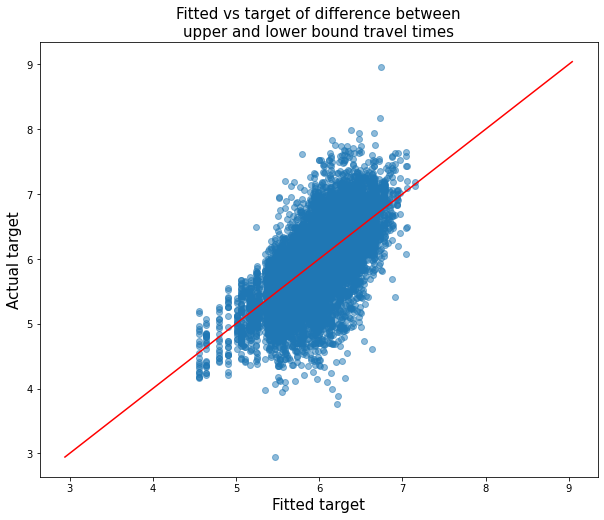

,R squared,RMSE
Fitted,0.429889,0.464348
Cross-Validated,0.315781,0.508326


In [106]:
df_res_bench = get_performance(clf_reg0, X0_train, y_train_open_ended, plot_file_name="train_bench_fitted")
df_res_bench

In [107]:
# Just beacuse we are curious, we want to see the performance when predicting average time instead
X_mt = df_reg.loc[:,"lockdown":]
y_mt = np.log(df_reg["mean_time"])
X_train_open_ended_mt, X_test_mt, y_train_open_ended_mt, y_test_mt = train_test_split(X_mt, y_mt, test_size=0.25, random_state=42)
dws = [f'dw_{i}' for i in range(1, 6+1)]
X0_train_mt = X_train_open_ended_mt.drop(columns=['lockdown'] + dws)
X0_test_mt = X_test.drop(columns=['lockdown'] + dws)

In [108]:
model = LinearRegression(fit_intercept=False)
clf_reg0_mean_time = model.fit(X0_train_mt, y_train_open_ended_mt)

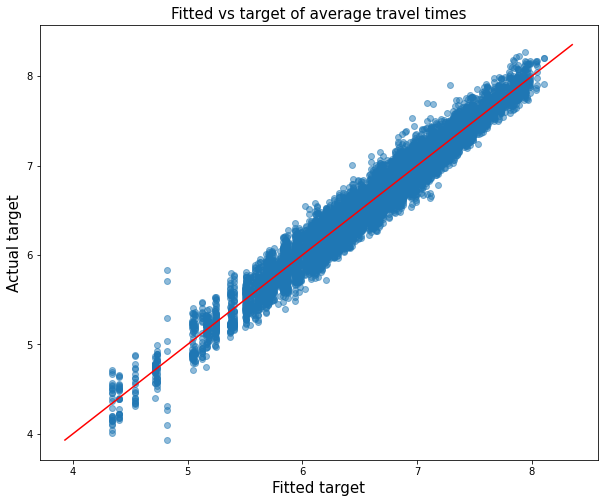

,R squared,RMSE
Fitted,0.956115,0.141790
Cross-Validated,0.938734,0.166991


In [109]:
df_res_bench_mt = get_performance(clf_reg0_mean_time, X0_train_mt, y_train_open_ended_mt, 
                                  plot_file_name="train_bench_fitted_mean_time", plot_title = 'Fitted vs target of average travel times')
df_res_bench_mt

A linear regression using only one-hot encoding of routes does a reasonable job already. R squared is 31.6% using cross-validation. There are two main forces determining the performance of this benchmark model. The first is that we are stacking routes of wildly different travel times together, and thus the diff between max and min should also be quite different between many routes. This helps in making the performance better. The second important factor is that we are not estimating the average of travel times, but the difference between the maximum and the minimum. Both the maximum and minimum are much more volatile than the average, and therefore there is much more noise in this target as compared with using average time. In fact, we tried the previous model using average times as the target and we got 94% cross-validated R squared! Thus, another factor to consider is that using one binary per route is incredibly informative, and we have enough data (rows) to include such a numerous set of features.

The big questions now are: 
- Will the lockdown variable help improve this benchmark model? 
- What other models can we consider besides OLS, and are they better? 
- Is the lockdown variable significant? 
- And finally, have we used this model with partial temporal information (i.e. as data became available), would it have done a good job in the real world?

We will answer these questions in the following parts.

## Question 5b

Improve on your baseline model. Specify the model you designed and its input features. Justify why you chose these features and their relevance to your model's predictions.

**Example**

Here are potential questions to consider for this part: How does the other variant of your travel times dataset, aggregated across time but reported for all routes, useful?  What additional data from the Uber Movement website can you export to better your model?

In [110]:
# Linear regression using lockdown and day of week
model = LinearRegression(fit_intercept=False)
clf_reg = model.fit(X_train_open_ended, y_train_open_ended)

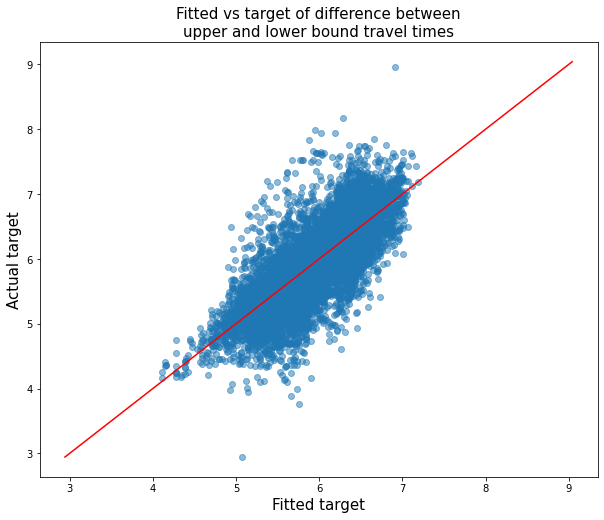

,R squared,RMSE
Fitted,0.603421,0.387283
Cross-Validated,0.511149,0.429614


In [111]:
df_res_lr = get_performance(clf_reg, X_train_open_ended, y_train_open_ended, plot_file_name="train_lr_fitted")
df_res_lr

In [112]:
# Ridge regression
parameters = {'alpha': np.linspace(0, 1, 21)}
model = Ridge(random_state=42)
clf_rdg_grid = GridSearchCV(model, parameters, cv=5)
clf_rdg_grid.fit(X_train_open_ended, y_train_open_ended)
clf_rdg = clf_rdg_grid.best_estimator_
print(f"best params: {clf_rdg_grid.best_params_}")

best params: {'alpha': 1.0}


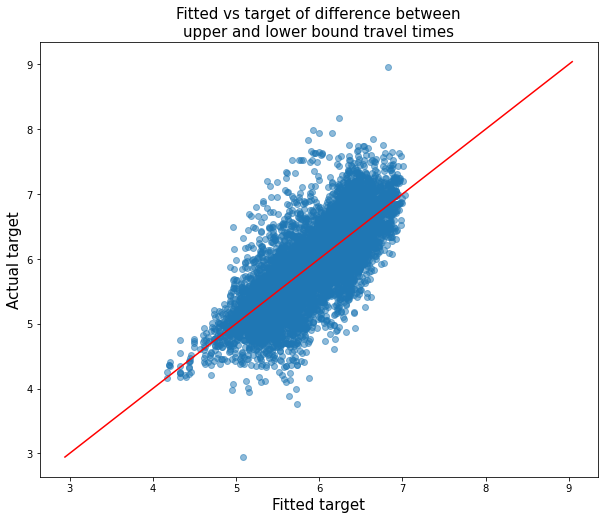

,R squared,RMSE
Fitted,0.601968,0.387992
Cross-Validated,0.533751,0.419757


In [113]:
df_res_rdg = get_performance(clf_rdg, X_train_open_ended, y_train_open_ended, plot_file_name="train_rdg_fitted")
df_res_rdg

In [114]:
# if you would like to reproduce finding the best hyperparamters, you can run the uncommented lines
# uncommented for the sake of shorter runtime, and we simply saved the best hyperparameters recorded

run_rf_bayes_search = False
"""
run_rf_bayes_search = True
if run_rf_bayes_search:
    parameters = {'n_estimators': np.arange(100, 225, 25),
                  'max_depth': [50, 100],
                 }
    model = RandomForestRegressor(random_state=42)
    clf_rf_grid = BayesSearchCV(model, parameters, n_iter=5, cv=5, verbose=2, random_state=42)
    clf_rf_grid.fit(X_train_open_ended, y_train_open_ended)
    clf_rf = clf_rf_grid.best_estimator_
    print(f"best params: {clf_rf_grid.best_params_}")
"""

'\nrun_rf_bayes_search = True\nif run_rf_bayes_search:\n    parameters = {\'n_estimators\': np.arange(100, 225, 25),\n                  \'max_depth\': [50, 100],\n                 }\n    model = RandomForestRegressor(random_state=42)\n    clf_rf_grid = BayesSearchCV(model, parameters, n_iter=5, cv=5, verbose=2, random_state=42)\n    clf_rf_grid.fit(X_train_open_ended, y_train_open_ended)\n    clf_rf = clf_rf_grid.best_estimator_\n    print(f"best params: {clf_rf_grid.best_params_}")\n'

In [115]:
# # So you don't have to run bayes search again (use the best hyperparameters found)
# if not run_rf_bayes_search:
#     clf_rf = RandomForestRegressor(n_estimators=200, max_depth=92, random_state=42)
#     clf_rf.fit(X_train_open_ended, y_train_open_ended)

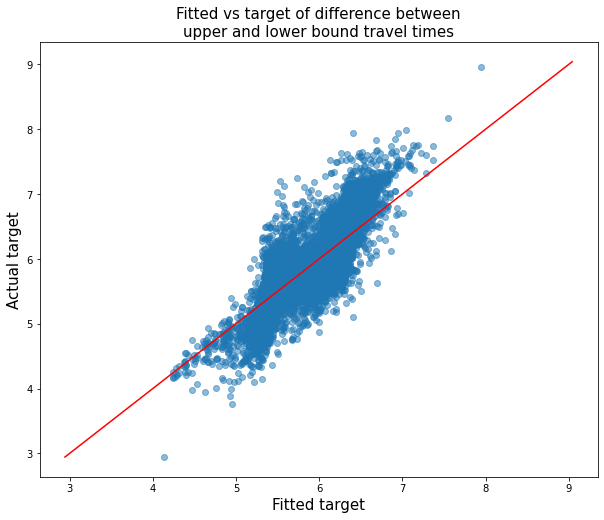

,R squared,RMSE
Fitted,0.664712,0.356100
Cross-Validated,0.432749,0.463011


In [116]:
# df_res_rf = get_performance(clf_rf, X_train_open_ended, y_train_open_ended, plot_file_name="train_rf_fitted")
# df_res_rf

In [117]:
# importances = clf_rf.feature_importances_[:7]
# std = np.std([tree.feature_importances_[:7] for tree in clf_rf.estimators_], axis=0)
# indices = np.argsort(importances)
# features = X_train_open_ended.columns[:7]
# forest_importances = pd.Series(importances, index=features)
# forest_std = pd.Series(std, index=features)
# forest_importances = forest_importances.sort_values()
# forest_std = forest_std.loc[forest_importances.index]

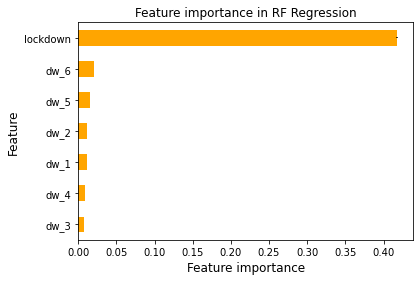

In [118]:
# fig, ax = plt.subplots()
# forest_importances.plot.barh(yerr=forest_std, ax=ax, color='orange')
# ax.set_title('Feature importance in RF Regression')
# ax.set_xlabel('Feature importance', fontsize=12)
# ax.set_ylabel('Feature', fontsize=12)
# plt.savefig(f'{image_folder}feature_importance.jpg', format='jpg', bbox_inches='tight', facecolor='white', edgecolor='none');
# plt.show();

In [119]:
# Source: https://www.statology.org/seaborn-barplot-show-values/
# Used to put numbers on the plot called by plot_performance
def show_values(axs, orient="v", space=.01, yfactor=0.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*yfactor)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

In [120]:
def plot_performance(df_res, metric, y_label, title, plot_name, y_mult=1, y_axis_delta=0.001, ylim=(0,1), leg_loc='upper left'):
    plt.figure(figsize=(10, 7))
    data_plot = df_res.loc[df_res.Metric == metric]
    data_plot['Value'] = data_plot['Value']*y_mult
    g = sns.barplot(x='Model', y='Value', hue='Scope', palette='rocket', data=data_plot)
    show_values(g, yfactor=y_axis_delta)
    plt.legend(loc=leg_loc, fontsize=12)
    plt.ylim(ylim)
    plt.title(title, fontsize=15)
    plt.ylabel(y_label, fontsize=15)
    plt.xlabel("Model", fontsize=15)
    plot_name = plot_name.replace(' ', '_')
    plt.savefig(f'{image_folder}{plot_name}.jpg', format='jpg', bbox_inches='tight', facecolor='white', edgecolor='none');

In [121]:
# df_res_dict = OrderedDict()
# df_res_dict['Benchmark'] = df_res_bench
# df_res_dict['Lin. Reg. full'] = df_res_lr
# df_res_dict['Ridge Reg.'] = df_res_rdg
# df_res_dict['RF Reg.'] = df_res_rf

In [122]:
cols = ['Scope', 'Metric', 'Value', 'Model']
df_res = pd.DataFrame(columns=cols)
rename = {'index': 'Scope'}
for model_name, df_res_i in df_res_dict.items():
    df_res_aux = \
    (df_res_i \
         .reset_index()
         .rename(columns=rename)
         .melt(id_vars=rename['index'], var_name='Metric', value_name='Value')
    )
    df_res_aux['Model'] = model_name
    df_res = df_res.append(df_res_aux)
df_res.loc[df_res.Scope == 'Fitted', 'Scope'] = 'Train'
df_res = df_res.reset_index(drop=True)

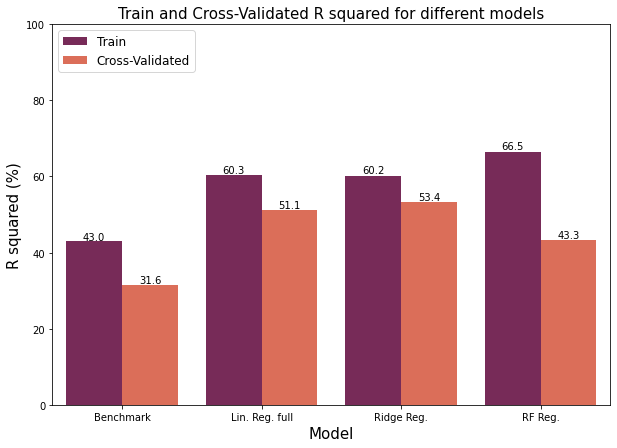

In [123]:
metric = "R squared"
title = f"Train and Cross-Validated {metric} for different models"
plot_performance(df_res, metric, f"{metric} (%)", title, f"results_train_{metric}", y_mult=100, y_axis_delta=0.01, ylim=(0, 100))

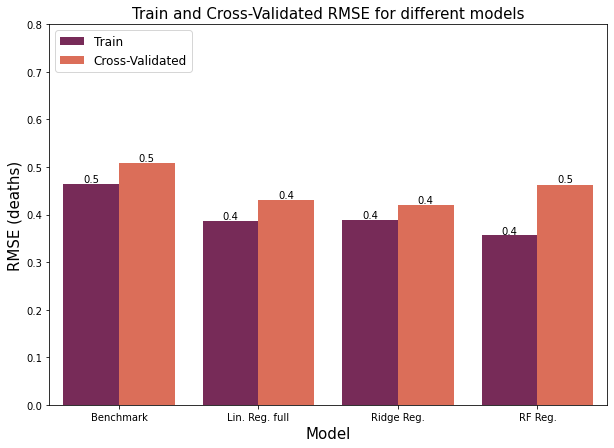

In [124]:
metric = "RMSE"
title = f"Train and Cross-Validated {metric} for different models"
plot_performance(df_res, metric, f"{metric} (deaths)", title, f"results_train_{metric}", y_axis_delta=0.01, ylim=(0, 0.8))

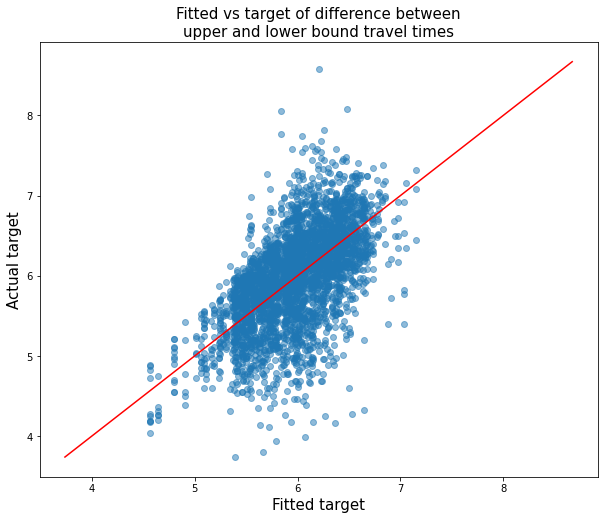

,R squared,RMSE
Fitted,3.342744e-01,4.964734e-01
Cross-Validated,-8.000833e+22,1.713716e+11


In [125]:
df_res_bench_test = get_performance(clf_reg0, X0_test, y_test, y_train_open_ended, plot_file_name="test_bench_fitted")
df_res_bench_test

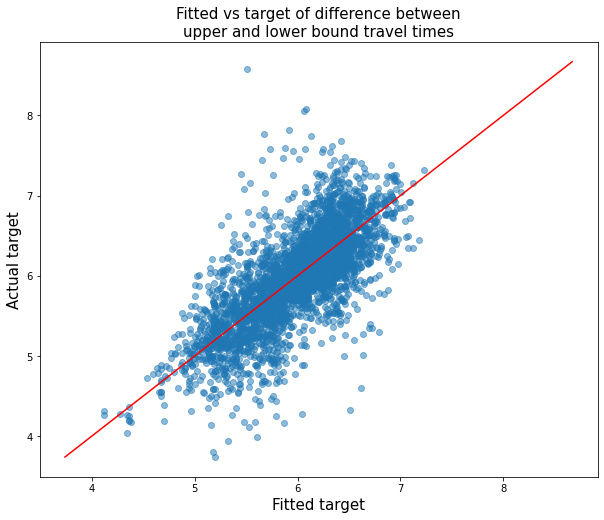

,R squared,RMSE
Fitted,5.294495e-01,4.173991e-01
Cross-Validated,-1.631084e+25,2.461423e+12


In [126]:
df_res_lr_test = get_performance(clf_reg, X_test, y_test, y_train_open_ended, plot_file_name="test_lr_fitted")
df_res_lr_test

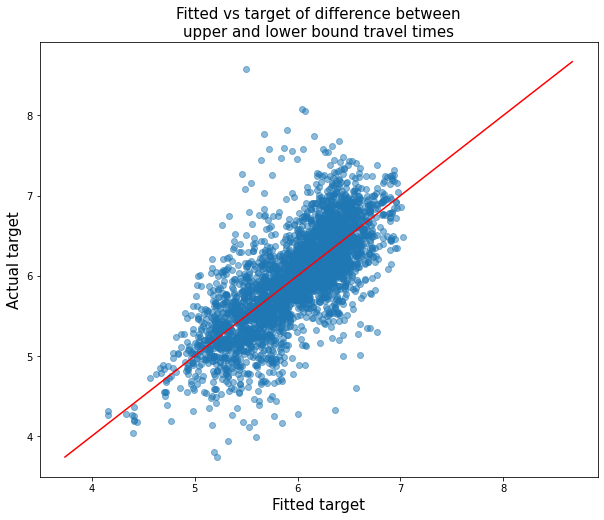

,R squared,RMSE
Fitted,0.535094,0.414888
Cross-Validated,0.470415,0.442389


In [127]:
df_res_rdg_test = get_performance(clf_rdg, X_test, y_test, y_train_open_ended, plot_file_name="test_ridge_fitted")
df_res_rdg_test

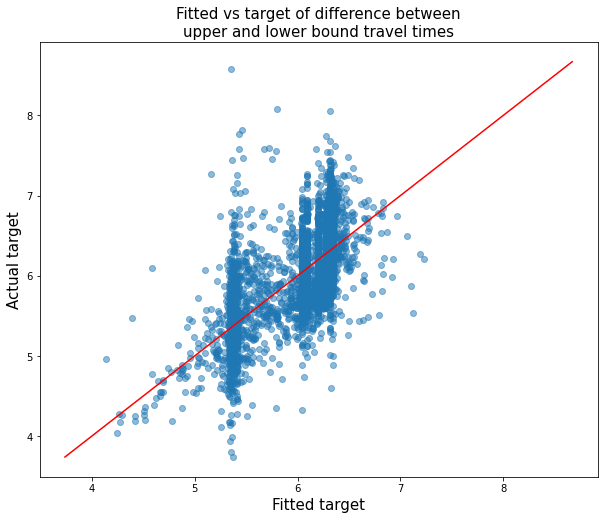

,R squared,RMSE
Fitted,0.437183,0.456491
Cross-Validated,0.392566,0.474038


In [128]:
df_res_rf_test = get_performance(clf_rf, X_test, y_test, y_train_open_ended, plot_file_name="test_rf_fitted")
df_res_rf_test

In [129]:
df_res_test_dict = OrderedDict()
df_res_test_dict['Benchmark'] = df_res_bench_test
df_res_test_dict['Lin. Reg. full'] = df_res_lr_test
df_res_test_dict['Ridge Reg.'] = df_res_rdg_test
df_res_test_dict['RF Reg.'] = df_res_rf_test

In [130]:
cols = ['Scope', 'Metric', 'Value', 'Model']
df_res_test = pd.DataFrame(columns=cols)
for model_name, df_res_i in df_res_test_dict.items():
    df_res_aux = \
    (df_res_i \
         .reset_index()
         .rename(columns=rename)
         .melt(id_vars=rename['index'], var_name='Metric', value_name='Value')
    )
    df_res_aux['Model'] = model_name
    df_res_test = df_res_test.append(df_res_aux)
df_res_test = df_res_test.loc[df_res_test.Scope == 'Fitted']
df_res_test.Scope = 'Test'
df_res_test = df_res_test.reset_index(drop=True)

In [131]:
df_res_test = df_res.loc[df_res.Model.isin(df_res_test.Model.unique())].append(df_res_test)

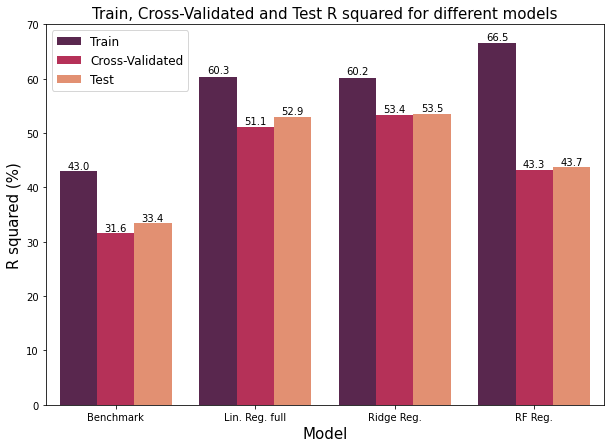

In [132]:
metric = "R squared"
title = f"Train, Cross-Validated and Test {metric} for different models"
plot_performance(df_res_test, metric, f"{metric} (%)", title, f"results_test_{metric}", y_mult=100, 
                 y_axis_delta=0.01, ylim=(0, 70), leg_loc='upper left')

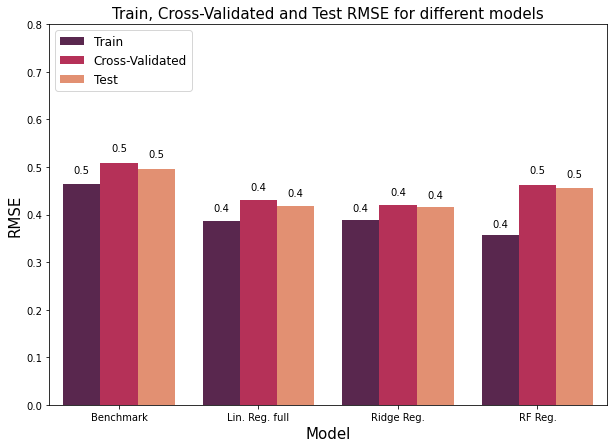

In [133]:
metric = "RMSE"
title = f"Train, Cross-Validated and Test {metric} for different models"
plot_performance(df_res_test, metric, f"{metric}", title, f"results_test_{metric}", y_mult=1, 
                 y_axis_delta=0.05, ylim=(0, 0.8), leg_loc='upper left')

We see that our benchmark model can be significantly improved by adding the lockdown variable and an indicator of the days of the week. R squared improved from 31.6% to 51.1% and RMSE improved from 0.51 to 0.43. 

RMSE is in the same units as y, which is log of travel time. We believe it is better to compute RMSE over the log of travel time difference, instead of travel time difference directly, because our target for different routes can be orders of magnitude apart. Thus, not using logs would end up biasing results into fitting correctly only the routes with the highest travel times diff overall.

We used Grid Search to search for the best -from a cross-validation perspective- Ridge model from a finite (and reasonable) selection of alphas. Using Grid Search for Random Forest could have taken days, months or years, depending on how vast your grid is. We decided to go with Bayes Search instead, which uses past hyperparameters tries and their performance to inform future searches. This method avoids wasting time trying hyperparameters in areas of the grid where performance has been bad.

We can see that our plain vanilla OLS algorithm is improved by using L2 regularization, i.e. by doing a Ridge regression instead. R squared improved from 51.1% to 53.4% and RMSE from 0.43 to 0.42. The improvement is not huge but it is existent. We therefore marginally prefer Ridge over OLS.

We see that Random Forest Regression is an improvement to the benchmark model in terms of performance, but it got far worse results than OLS and Ridge. The Ridge regression is then our model of choice and we will analyze its results further in the next part.

Finally, notice that the results of the Ridge model was very similar for the test set, with an R squared of 53.5% and a RMSE of 0.41, i.e. marginally better in R squared and RMSE than in the cross-validated metrics, but overall we can say that our cross-validated results were a fair representation of the performance for this out-of-sample set. We have to stress though, that this test is not the most appropriate check we can perform as we are treating the data as strictly cross-sectional. The time-series nature demands more care in the performance analysis, and this will be analyzed in the next part in the Backtesting subpart.

## Question 5c

Explore other modeling aspects and/or temporal information. You are free to relate this to your hypothesis or not. Please expand into multiple parts that logically separate and break down your modeling work!

**Example**

For example, explore change across time, before and after the lockdown: (a) train and evaluate on *pre*-lockdown traffic travel times for that route; and (b) evaluate your model on *post*-lockdown traffic patterns.
How would you correct your model for a more accurate post-lockdown traffic predictor? *The above is just a suggestion. You may pick any topic you find interesting.*

#### Inference

In [134]:
mod = sm.OLS(y_train_open_ended, X_train_open_ended)
res = mod.fit()

In [135]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       diff_upper_lower   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     20.99
Date:                Mon, 13 Dec 2021   Prob (F-statistic):               0.00
Time:                        00:07:33   Log-Likelihood:                -4836.5
No. Observations:               10283   AIC:                         1.106e+04
Df Residuals:                    9587   BIC:                         1.610e+04
Df Model:                         695                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
lockdown           -0.5954      0.010    -62.044      0.000      -0.614      -0.577
dw_1                0.1063      0.015      7.333      0.000       0.078       0.135
dw_2                0.0660      0.015      4.448      0.000       0.037       0.095
dw_3                0.0803      0.015      5.395      0.000       0.051       0.110
dw_4               -0.0017      0.015     -0.114      0.910      -0.031       0.027
dw_5               -0.1268      0.015     -8.375      0.000      -0.156      -0.097
dw_6               -0.1662      0.014    -11.801      0.000      -0.194      -0.139
route_1277-102      6.8390      0.142     48.137      0.000       6.561       7.118
route_1277-1025     6.3445      0.121     52.280      0.000       6.107       6.582
route_1277-1030     6.2307      0.090     69.054      0.000       6.054       6.408
route_1277-1031     6.3643      0.116     54.822      0.000       6.137       6.592
route_1277-1032     6.3490      0.092     68.644      0.000       6.168       6.530
route_1277-1036     6.2005      0.116     53.372      0.000       5.973       6.428
route_1277-1045     6.4657      0.121     53.277      0.000       6.228       6.704
route_1277-1046     6.2376      0.084     74.067      0.000       6.072       6.403
route_1277-1047     6.6499      0.116     57.284      0.000       6.422       6.877
route_1277-1048     6.4255      0.142     45.169      0.000       6.147       6.704
route_1277-1049     6.3096      0.127     49.588      0.000       6.060       6.559
route_1277-1053     6.2172      0.098     63.566      0.000       6.026       6.409
route_1277-1056     6.4968      0.127     51.066      0.000       6.247       6.746
route_1277-1057     6.1990      0.095     65.258      0.000       6.013       6.385
route_1277-1060     6.5252      0.084     77.513      0.000       6.360       6.690
route_1277-1063     6.6373      0.090     73.588      0.000       6.461       6.814
route_1277-1066     6.5649      0.090     72.780      0.000       6.388       6.742
route_1277-1068     6.2973      0.076     82.396      0.000       6.147       6.447
route_1277-1069     6.6852      0.101     66.424      0.000       6.488       6.882
route_1277-1072     6.0709      0.134     45.250      0.000       5.808       6.334
route_1277-1073     6.5177      0.180     36.262      0.000       6.165       6.870
route_1277-1074     6.5620      0.127     51.605      0.000       6.313       6.811
route_1277-1079     6.4128      0.134     47.837      0.000       6.150       6.676
route_1277-108      6.3248      0.201     31.482      0.000       5.931       6.719
route_1277-1080     6.3049      0.095     66.241      0.000       6.118       6.491
route_1277-1081     6.6838      0.201     33.312      0.000       6.290       7.077
route_1277-1087     6.3551      0.116     54.713      0.000

In [136]:
# Inference using statsmodels: 
# Is theta (coefficient accompanying lockdown variable) significant?
theta_sm = res.params[0]
tstat_sm = res.tvalues[0]
pval_sm = res.pvalues[0]
print(f"""
theta = {theta_sm}
t-statistic = {tstat_sm}
p-value = {pval_sm}
""")


theta = -0.5954369732088496
t-statistic = -62.04426962093026
p-value = 0.0



In [137]:
# Using sklearn model
theta = clf_rdg.coef_[0]
shriking_factor = np.exp(theta)
print(f"""
theta: {theta}
shrinking_factor: {shriking_factor}
""")


theta: -0.6071755214595239
shrinking_factor: 0.5448877213255419



In [138]:
# Days of the week significance
# Again 0 is Monday (it was removed due to linear dependence) and 6 is Sunday
theta_dw_sm = res.params[1:7]
shrinking_factor_dw_sm = np.exp(res.params[1:7])
tstat_dw_sm = res.tvalues[1:7]
pval_dw_sm = res.pvalues[1:7]
print(f"""
theta_dw_sm {theta_dw_sm}
shrinking_facotr_dw_sm {shrinking_factor_dw_sm}
tstat_dw_sm {tstat_dw_sm}
pval_dw_sm {pval_dw_sm}
""")


theta_dw_sm dw_1    0.106346
dw_2    0.065951
dw_3    0.080340
dw_4   -0.001678
dw_5   -0.126788
dw_6   -0.166151
dtype: float64
shrinking_facotr_dw_sm dw_1    1.112206
dw_2    1.068174
dw_3    1.083655
dw_4    0.998323
dw_5    0.880921
dw_6    0.846919
dtype: float64
tstat_dw_sm dw_1     7.333020
dw_2     4.448064
dw_3     5.395002
dw_4    -0.113557
dw_5    -8.375324
dw_6   -11.801170
dtype: float64
pval_dw_sm dw_1    2.432531e-13
dw_2    8.762409e-06
dw_3    7.015508e-08
dw_4    9.095914e-01
dw_5    6.280007e-17
dw_6    6.398022e-32
dtype: float64



Now we check wether lockdown or days of the week are significant. Using statsmodels we found out the t-statistic and p-value of the mentioned coefficients. The lockdown variable is immensely significant with a t-statistic of -62 and a p-value of virtually 0 in the OLS case. Given the high similarity between OLS and Ridge, and the outstanding significance, it is reasonable to conclude that the theta coefficient is also highly significant in the Ridge model. Basically, we can be sure that the lockdown had a significant impact on travel times diff. A strong reduction of the difference between the maximum and the minimum is a clear indication that the dispersion of travel times was reduced greatly. There is a very simple cause for this reduction in the travel time range or dispersion: the streets had significantly less traffic. Besides just saying that the reduction in the max-min diff was significant, we can also quantify this impact which can be very useful for the real situation faced by Uber. We found an optimal value of theta (in the train data) of -0.61, which translates into a shrinking factor of 0.54. This means that based on our best estimation, travel times max-min diff was reduced by 46% due to the lockdown measure.

The days of the week are also significant. We dropped the binary variable linked to Mondays to avoid linear dependence in the columns of the design matrix. We see that travel times max-min diff on Tuesdays to Thursdays tend to be higher than on Monday, while weekends see a significant reduction when compared to Mondays (12% for Saturdays and 15% for Sundays). All weekday adjustments are highly significant with the exception of Fridays which has a t-statistic of -0.1 and a p-value of 9.1%.

#### Backtest

In [139]:
test_days = list(range(18, 31+1))
test_days

[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

In [140]:
thetas = []
r2s = []
rmses = []

for test_day in test_days:
    print(test_day, end = ' ')
    
    # Train and test data for test_day
    bool_train = df_reg.day < test_day
    bool_test = df_reg.day == test_day
    X_train_open_ended = df_reg.loc[bool_train, "lockdown":]
    y_train_open_ended = np.log(df_reg.loc[bool_train, "diff_upper_lower"])
    X_test = df_reg.loc[bool_test, "lockdown":]
    y_test = np.log(df_reg.loc[bool_test, "diff_upper_lower"])
    
    # Fit model
    model = Ridge(alpha=1.0, random_state=42)
    clf_bt = model.fit(X_train_open_ended, y_train_open_ended)
    
    # Results
    theta = clf_bt.coef_[0]
    pred = clf_bt.predict(X_test)
    error = y_test - pred
    r2 = 1 - np.sum(error**2)/np.sum((y_test - np.mean(y_train_open_ended))**2)
    rmse = np.sqrt(np.mean(error**2))
    thetas.append(theta)
    r2s.append(r2)
    rmses.append(rmse)

18 19 20 21 22 23 24 25 26 27 28 29 30 31 

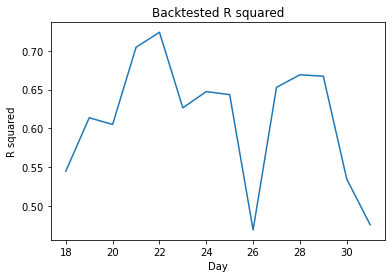

In [141]:
plt.plot(test_days, r2s)
plt.title("Backtested R squared")
plt.xlabel("Day")
plt.ylabel("R squared");

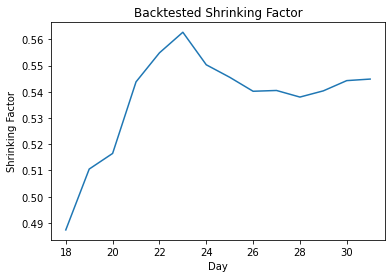

In [142]:
plt.plot(test_days, np.exp(np.array(thetas)))
plt.title("Backtested Shrinking Factor")
plt.xlabel("Day")
plt.ylabel("Shrinking Factor");

Here we do a proper test using the temporal nature of the problem. As we mentioned before, obtaining a test set at random is not the best practice because we would be using in most cases information from the _future and the past to forecast anything in between_. What should be done is to use only the past data to forecast the days following. In this backtest, we see what would have been the result if we had used our Ridge model trained only on past data up to day 16 to forecast 17, and from there using all past information to forecast the next day, i.e. we then use information up to day 17 to forecast 18, then up to 18 to forecast 19, and so on.

The R squared was computed for each test day individually. We can see that it was very high despite how much harder it is to forecast the travel time max-min diff, instead of say travel time averages. R squared ranges from around 50% to around 70%, which we believe is quite remarkable.

Finally, we show the shrinking factor computed, which is equal to $exp(\theta)$ and can be interpreted as the factor that multiplies the forecast pre-lockdown to get the forecast post-lockdown. Given that our training set in this exercise is an expanding window and that the first run has seen only one full day of lockdown, is that the values changes more in the first days post-lockdown and tends to stabilize after around 1 week of data. Nevertheless, we can see that the estimation of the shrinking factor with only one day of data (0.49) was not too far away of the shrinking factor computed using all the data (0.54), and thus it would have been a very reasonable adjustment to apply in the early days of the lockdown given the urgent situation the company was facing.

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [143]:
grader.check_all()

q1a results: All test cases passed!

q1bi results: All test cases passed!

q1bii results: All test cases passed!

q1biii results: All test cases passed!

q1biv results: All test cases passed!

q1bv3 results: All test cases passed!

q1ci results: All test cases passed!

q1cii results: All test cases passed!

q1ciii results: All test cases passed!

q1civ3 results: All test cases passed!

q2ai2 results: All test cases passed!

q2ai3 results: All test cases passed!

q2ai4 results: All test cases passed!

q2aii2 results: All test cases passed!

q2aiii results: All test cases passed!

q2aiv3 results: All test cases passed!

q2av2 results: All test cases passed!

q4ai1 results: All test cases passed!

q4ai2 results: All test cases passed!

q4ai3 results: All test cases passed!

q4aii2 results: All test cases passed!

q4bi1 results: All test cases passed!

q4ci2 results: All test cases passed!

q4ci3 results: All test cases passed!

q4ci4 results: All test cases passed!

q4ci5 results: All tes

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [145]:
# Save your notebook first, then run this cell to export your submission.
grader.export()